In [1]:
# import the necessary libraries
import os
import requests
import time
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
import ast
import re
import string
import json



from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from wordcloud import WordCloud

from transformers import pipeline
from nltk.corpus import stopwords
from pandas_profiling import ProfileReport

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import KNNImputer



2023-08-15 16:25:17.304861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 16:25:18.011196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_6102/2834710498.py:30: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
# base URL for the Kijiji website
base_url = "https://www.kijiji.ca"

def get_adlinks_urls_from_listing_page(url):
    
    # use requests library to get response
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
    # find all of the relevant ads
    ads = soup.find_all("div", attrs={"class": ["search-item", "regular-ad"]})
    # removes marketing / third party ads
    ads = [x for x in ads if ("cas-channel" not in x["class"]) & ("third-party" not in x["class"])]
    # create a list to store all of the URLs from the 
    ad_links = []
    for ad in ads:
        # parse the link from the ad
        link = ad.find_all("a", {"class": "title"})
        # add the link to the list
        for l in link:
            ad_links.append(base_url + l["href"])
        
    return ad_links

In [3]:
def get_individual_ad_html(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
    
    return soup

In [4]:
def extract_description(html):
    # Find the heading with text 'Description'
    description_heading = html.find("h3", text="Description")

    if description_heading:
        
        try:
            # Use find_next_sibling() to get the next sibling element, which should be the body text
            body_text = description_heading.find_next_sibling().text.strip()
        except Exception as err:
            print(err)
            return None
#         print(body_text)
    else:
        print("Description not found.")
        body_text = "Description not found"
        
    return body_text
        
def extract_title(html):
    title = html.find("h1").text
    return title

def extract_price(html):
#     price_element = html.select_one('[class^="price-"]')
    price_element=html.find("div", class_="priceContainer-1419890179")

    # Extract the price value
    if price_element:
        price = price_element.text.strip()
#         print(price)
    else:
        price = "Price not found"
    return price

In [5]:
def extract_attributes(html):
    # Initialize a dictionary to store the key-value pairs
    key_value_pairs = {}

    div_element = html
    # Find all the <dt> and <dd> elements within the <div>
    dt_elements = div_element.select('dt[class^="attributeLabel-"]')
    dd_elements = div_element.select('dd[class^="attributeValue-"]')

    # Extract the key-value pairs and add them to the dictionary
    for dt, dd in zip(dt_elements, dd_elements):
        key = dt.text.strip()
        value = dd.text.strip()
        key_value_pairs[key] = value
            
    return key_value_pairs

# extract_attributes(sample_ad_html)

In [6]:
def extract_location(html):
    
    img_tag = html.find("img", class_="mapImage-52463451")
    if img_tag and 'alt' in img_tag.attrs:
        # Extract the 'src' attribute from the <img> tag
        alt_attr = img_tag.get("alt")
        return alt_attr
def extract_seller(html):
    seller_div = html.find("div", class_="line-2791721720")

    if seller_div:
        # Extract the text from the div
        seller = seller_div.text.strip()
    else:
        seller = "seller not found"
    return seller

In [7]:
sample_page_url = "https://www.kijiji.ca/b-house-for-sale/canada/page-2/c35l0"
def get_house_details_page(page=2):
    page_url = sample_page_url.replace("page-2","page-"+str(page))
    ad_links = get_adlinks_urls_from_listing_page(page_url)
    page_data = []
    for link in ad_links:

        html = get_individual_ad_html(link)
        

        house_infodict = {"url":link,
                               "title":extract_title(html),
                               "description":extract_description(html),
                               "attributes":extract_attributes(html),
                               "location":extract_location(html),
                               "seller":extract_seller(html),
                               "price":extract_price(html)
                               
                              }
        page_data.append(house_infodict)
    
    page_df = pd.DataFrame(page_data)
    
    return page_df
# page2_df = get_house_details_page(page=2)

In [12]:

for i in range(101):
    print(i)
    page_df = get_house_details_page(page=i)
    page_df.to_csv("pages_data/page_"+str(i)+".csv", index=None)

36
37
38
39
40
41
42
43
44
45
Description not found.
46
47
48
Description not found.
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


# Analysis

In [2]:
# Reading pages data from all the files which are saved in "pages/data" location
files_list = os.listdir("pages_data/")

pages_df_list = [pd.read_csv(os.path.join("pages_data",file)) for file in files_list]
pages_df = pd.concat(pages_df_list)
pages_df.head()

url   
0  https://www.kijiji.ca/v-house-for-sale/charlot...  \
1  https://www.kijiji.ca/v-house-for-sale/winnipe...   
2  https://www.kijiji.ca/v-house-for-sale/oshawa-...   
3  https://www.kijiji.ca/v-house-for-sale/red-dee...   
4  https://www.kijiji.ca/v-house-for-sale/cornwal...   

                                               title   
0                    Awesome cottage! Price reduced!  \
1                       Cottage on Lake Of The Woods   
2        4 Bedrooms/3 Baths/ 4 Car Parking/Huge Lot    
3            REDUCED!!! 75 Thompson Cresent Red Deer   
4   House for sale north end of Cornwall 3015 Pit...   

                                         description   
0  Beautiful winterized cottage minutes to North ...  \
1  Don't miss this water front water access hidde...   
2  Fantastic Opportunity To Own A Fully Detached ...   
3  REDUCED!! House inspection completed in Septem...   
4  Beautiful ready to move in 1000 square-foot ho...   

                                          attributes location        seller   
0                {'Bedrooms': '2', 'Bathrooms': '1'}      NaN  Professional  \
1  {'Bedrooms': '4', 'Bathrooms': '1', 'Size (sqf...      NaN  Professional   
2                {'Bedrooms': '4', 'Bathrooms': '3'}      NaN  Professional   
3  {'Bedrooms': '5', 'Bathrooms': '3', 'Size (sqf...      NaN         Owner   
4  {'Bedrooms': '2', 'Bathrooms': '1', 'Size (sqf...      NaN         Owner   

              price  
0  $309,900FEATURED  
1  $355,000FEATURED  
2          $725,000  
3  $535,000FEATURED  
4  $269,000FEATURED

In [3]:
pages_df.shape

(4500, 7)

In [4]:
pages_df.isna().sum()

url               0
title             3
description       0
attributes        0
location       1519
seller            0
price             0
dtype: int64

In [5]:
pages_df.describe()

url   
count                                                4500  \
unique                                               3960   
top     https://www.kijiji.ca/v-house-for-sale/kitimat...   
freq                                                   16   

                                              title   
count                                          4497  \
unique                                         3872   
top     Cabin on Lake of the Woods, Kenora District   
freq                                             16   

                                              description   
count                                                4500  \
unique                                               3907   
top     Don't miss this water front water access hidde...   
freq                                                   16   

                                 attributes   
count                                  4500  \
unique                                  518   
top     {'Bedrooms': '3', 'Bathrooms': '2'}   
freq                                    474   

                                      location        seller           price  
count                                     2981          4500            4500  
unique                                    2872             6            1462  
top     1235 Villiers Line, Keene, ON, K0L 2G0  Professional  Please Contact  
freq                                        15          3536             189

In [6]:
# dropping duplicates
pages_df.drop_duplicates(inplace=True)

In [7]:
pages_df

url   
0   https://www.kijiji.ca/v-house-for-sale/charlot...  \
1   https://www.kijiji.ca/v-house-for-sale/winnipe...   
2   https://www.kijiji.ca/v-house-for-sale/oshawa-...   
3   https://www.kijiji.ca/v-house-for-sale/red-dee...   
4   https://www.kijiji.ca/v-house-for-sale/cornwal...   
..                                                ...   
40  https://www.kijiji.ca/v-house-for-sale/moose-j...   
41  https://www.kijiji.ca/v-house-for-sale/calgary...   
42  https://www.kijiji.ca/v-house-for-sale/strathc...   
43  https://www.kijiji.ca/v-house-for-sale/kingsto...   
44  https://www.kijiji.ca/v-house-for-sale/edmonto...   

                                                title   
0                     Awesome cottage! Price reduced!  \
1                        Cottage on Lake Of The Woods   
2         4 Bedrooms/3 Baths/ 4 Car Parking/Huge Lot    
3             REDUCED!!! 75 Thompson Cresent Red Deer   
4    House for sale north end of Cornwall 3015 Pit...   
..                                                ...   
40            117 3rd STREET Drinkwater, Saskatchewan   
41  34141 Township Road 241 Rural Rocky View Count...   
42   572015 164 RANGE RD Rural Lamont County, Alberta   
43              334 BUCKTHORN Drive Kingston, Ontario   
44           1240 twp 502 Rural Leduc County, Alberta   

                                          description   
0   Beautiful winterized cottage minutes to North ...  \
1   Don't miss this water front water access hidde...   
2   Fantastic Opportunity To Own A Fully Detached ...   
3   REDUCED!! House inspection completed in Septem...   
4   Beautiful ready to move in 1000 square-foot ho...   
..                                                ...   
40  MLS® #SK930776\nSpacious 3 bedroom house locat...   
41  MLS® #A2044152\nOnly 25 Minutes to Downtown Ca...   
42  MLS® #E4343160\nWelcome to this 2 + 2 bedroom ...   
43  MLS® #40411688\nBrand new from CaraCo, the Sta...   
44  MLS® #E4338293\nSpectacular hidden gem on 159....   

                                           attributes   
0                 {'Bedrooms': '2', 'Bathrooms': '1'}  \
1   {'Bedrooms': '4', 'Bathrooms': '1', 'Size (sqf...   
2                 {'Bedrooms': '4', 'Bathrooms': '3'}   
3   {'Bedrooms': '5', 'Bathrooms': '3', 'Size (sqf...   
4   {'Bedrooms': '2', 'Bathrooms': '1', 'Size (sqf...   
..                                                ...   
40                {'Bedrooms': '3', 'Bathrooms': '2'}   
41                {'Bedrooms': '5', 'Bathrooms': '5'}   
42                {'Bedrooms': '4', 'Bathrooms': '2'}   
43                {'Bedrooms': '3', 'Bathrooms': '3'}   
44                {'Bedrooms': '1', 'Bathrooms': '2'}   

                                             location        seller   
0                                                 NaN  Professional  \
1                                                 NaN  Professional   
2                                                 NaN  Professional   
3                                                 NaN         Owner   
4                                                 NaN         Owner   
..                                                ...           ...   
40             117 3rd STREET, Drinkwater, SK, S0H1G0  Professional   
41  34141 Township Road 241, Rural Rocky View Coun...  Professional   
42  572015 164 RANGE RD, Rural Lamont County, AB, ...  Professional   
43          334 BUCKTHORN Drive, Kingston, ON, K7P0S1  Professional   
44       1240 twp 502, Rural Leduc County, AB, T0C2P0  Professional   

               price  
0   $309,900FEATURED  
1   $355,000FEATURED  
2           $725,000  
3   $535,000FEATURED  
4   $269,000FEATURED  
..               ...  
40          $149,000  
41        $1,649,000  
42          $219,900  
43          $599,900  
44        $1,195,000  

[3960 rows x 7 columns]

## Filtering out data based on the attributes.


In [8]:
pages_df.attributes = pages_df.attributes.map(lambda x: ast.literal_eval(x))

In [9]:
attributes_list = pages_df.attributes.to_list()
attributes_list

[{'Bedrooms': '2', 'Bathrooms': '1'},
 {'Bedrooms': '4', 'Bathrooms': '1', 'Size (sqft)': '1,400'},
 {'Bedrooms': '4', 'Bathrooms': '3'},
 {'Bedrooms': '5', 'Bathrooms': '3', 'Size (sqft)': '1,343'},
 {'Bedrooms': '2', 'Bathrooms': '1', 'Size (sqft)': '1,000'},
 {'Bedrooms': '3', 'Bathrooms': '3'},
 {'Bedrooms': '4', 'Bathrooms': '5'},
 {'Bedrooms': '3', 'Bathrooms': '2', 'Size (sqft)': '1,700'},
 {'Bedrooms': '4', 'Bathrooms': '3', 'Size (sqft)': '1,670'},
 {'Bedrooms': '1', 'Bathrooms': '1', 'Size (sqft)': '639'},
 {'Bedrooms': '3', 'Bathrooms': '2', 'Size (sqft)': '1,800'},
 {'Bedrooms': '2', 'Bathrooms': '3', 'Size (sqft)': '1,250'},
 {'Bedrooms': '3', 'Bathrooms': '4'},
 {'Bedrooms': '3', 'Bathrooms': '4'},
 {'Bedrooms': '3', 'Bathrooms': '3'},
 {'Bedrooms': '4', 'Bathrooms': '4'},
 {'Bedrooms': '4', 'Bathrooms': '4'},
 {'Bedrooms': '3', 'Bathrooms': '5'},
 {'Bedrooms': '3', 'Bathrooms': '4'},
 {'Bedrooms': '3', 'Bathrooms': '4'},
 {'Bedrooms': '3', 'Bathrooms': '3'},
 {'Bedrooms'

In [10]:
attributes_set = {key  for attribute_dict in attributes_list for key in attribute_dict.keys()}
print(len(attributes_set))
attributes_set

6


{'Bathrooms',
 'Bedrooms',
 'Chambres à coucher',
 'Salles de bain',
 'Size (sqft)',
 'Taille (pieds carrés)'}

In [11]:
# Following are the translations of the french attributes
# 'Chambres à coucher' - bedrooms
# 'Salles de bain' - Bathroom
# 'Taille (pieds carrés)' - Size in sq ft

# Feature extraction

### Extracting features from the column attributes


In [12]:
for attribute in attributes_set:
    pages_df[attribute] = pages_df.attributes.map(lambda x: x.get(attribute,None))
pages_df

url   
0   https://www.kijiji.ca/v-house-for-sale/charlot...  \
1   https://www.kijiji.ca/v-house-for-sale/winnipe...   
2   https://www.kijiji.ca/v-house-for-sale/oshawa-...   
3   https://www.kijiji.ca/v-house-for-sale/red-dee...   
4   https://www.kijiji.ca/v-house-for-sale/cornwal...   
..                                                ...   
40  https://www.kijiji.ca/v-house-for-sale/moose-j...   
41  https://www.kijiji.ca/v-house-for-sale/calgary...   
42  https://www.kijiji.ca/v-house-for-sale/strathc...   
43  https://www.kijiji.ca/v-house-for-sale/kingsto...   
44  https://www.kijiji.ca/v-house-for-sale/edmonto...   

                                                title   
0                     Awesome cottage! Price reduced!  \
1                        Cottage on Lake Of The Woods   
2         4 Bedrooms/3 Baths/ 4 Car Parking/Huge Lot    
3             REDUCED!!! 75 Thompson Cresent Red Deer   
4    House for sale north end of Cornwall 3015 Pit...   
..                                                ...   
40            117 3rd STREET Drinkwater, Saskatchewan   
41  34141 Township Road 241 Rural Rocky View Count...   
42   572015 164 RANGE RD Rural Lamont County, Alberta   
43              334 BUCKTHORN Drive Kingston, Ontario   
44           1240 twp 502 Rural Leduc County, Alberta   

                                          description   
0   Beautiful winterized cottage minutes to North ...  \
1   Don't miss this water front water access hidde...   
2   Fantastic Opportunity To Own A Fully Detached ...   
3   REDUCED!! House inspection completed in Septem...   
4   Beautiful ready to move in 1000 square-foot ho...   
..                                                ...   
40  MLS® #SK930776\nSpacious 3 bedroom house locat...   
41  MLS® #A2044152\nOnly 25 Minutes to Downtown Ca...   
42  MLS® #E4343160\nWelcome to this 2 + 2 bedroom ...   
43  MLS® #40411688\nBrand new from CaraCo, the Sta...   
44  MLS® #E4338293\nSpectacular hidden gem on 159....   

                                           attributes   
0                 {'Bedrooms': '2', 'Bathrooms': '1'}  \
1   {'Bedrooms': '4', 'Bathrooms': '1', 'Size (sqf...   
2                 {'Bedrooms': '4', 'Bathrooms': '3'}   
3   {'Bedrooms': '5', 'Bathrooms': '3', 'Size (sqf...   
4   {'Bedrooms': '2', 'Bathrooms': '1', 'Size (sqf...   
..                                                ...   
40                {'Bedrooms': '3', 'Bathrooms': '2'}   
41                {'Bedrooms': '5', 'Bathrooms': '5'}   
42                {'Bedrooms': '4', 'Bathrooms': '2'}   
43                {'Bedrooms': '3', 'Bathrooms': '3'}   
44                {'Bedrooms': '1', 'Bathrooms': '2'}   

                                             location        seller   
0                                                 NaN  Professional  \
1                                                 NaN  Professional   
2                                                 NaN  Professional   
3                                                 NaN         Owner   
4                                                 NaN         Owner   
..                                                ...           ...   
40             117 3rd STREET, Drinkwater, SK, S0H1G0  Professional   
41  34141 Township Road 241, Rural Rocky View Coun...  Professional   
42  572015 164 RANGE RD, Rural Lamont County, AB, ...  Professional   
43          334 BUCKTHORN Drive, Kingston, ON, K7P0S1  Professional   
44       1240 twp 502, Rural Leduc County, AB, T0C2P0  Professional   

               price Bathrooms Bedrooms Chambres à coucher   
0   $309,900FEATURED         1        2               None  \
1   $355,000FEATURED         1        4               None   
2           $725,000         3        4               None   
3   $535,000FEATURED         3        5               None   
4   $269,000FEATURED         1        2               None   
..               ...       ...      ...                ...   
40          $149,000   

# Combining french and english attributes

## 1. Bedroom and Chambres à coucher

In [13]:
# Checking if there are records with values in both columns
pages_df.Bedrooms[pages_df['Chambres à coucher'].isna()==False].value_counts()

Series([], Name: count, dtype: int64)

In [14]:
pages_df.Bedrooms.isna().sum()

264

In [15]:
pages_df.loc[pages_df.Bedrooms.isna(), 'Bedrooms'] = pages_df.loc[pages_df.Bedrooms.isna(), 'Chambres à coucher']
pages_df.Bedrooms.isna().sum()

3

## 2. Bathroom and Salles de bain 

In [16]:
# Checking if there are records with values in both columns
pages_df.Bathrooms[pages_df['Salles de bain'].isna()==False].value_counts()

Series([], Name: count, dtype: int64)

In [17]:
pages_df.Bathrooms.isna().sum()

264

In [18]:
pages_df.loc[pages_df.Bathrooms.isna(), 'Bathrooms'] = pages_df.loc[pages_df.Bathrooms.isna(), 'Salles de bain']
pages_df.Bathrooms.isna().sum()

3

## 3. Size (sqft) and Taille (pieds carrés)

In [19]:
pages_df['Size (sqft)'][pages_df['Taille (pieds carrés)'].isna()==False].value_counts()

Series([], Name: count, dtype: int64)

In [20]:
pages_df['Size (sqft)'].isna().sum()

3475

In [21]:
pages_df[(pages_df['Size (sqft)'].isna()) & (pages_df['Taille (pieds carrés)'].isna()==False)]

url   
27  https://www.kijiji.ca/v-maison-a-vendre/ville-...  \
3   https://www.kijiji.ca/v-maison-a-vendre/longue...   
12  https://www.kijiji.ca/v-maison-a-vendre/ville-...   
14  https://www.kijiji.ca/v-maison-a-vendre/sherbr...   
3   https://www.kijiji.ca/v-maison-a-vendre/lauren...   
33  https://www.kijiji.ca/v-maison-a-vendre/drummo...   
38  https://www.kijiji.ca/v-maison-a-vendre/sherbr...   
30  https://www.kijiji.ca/v-maison-a-vendre/lac-sa...   
21  https://www.kijiji.ca/v-maison-a-vendre/lanaud...   
31  https://www.kijiji.ca/v-maison-a-vendre/granby...   
44  https://www.kijiji.ca/v-maison-a-vendre/lanaud...   
13  https://www.kijiji.ca/v-maison-a-vendre/lauren...   
23  https://www.kijiji.ca/v-maison-a-vendre/laval-...   
14  https://www.kijiji.ca/v-maison-a-vendre/saint-...   
15  https://www.kijiji.ca/v-maison-a-vendre/saint-...   
16  https://www.kijiji.ca/v-maison-a-vendre/saint-...   
20  https://www.kijiji.ca/v-maison-a-vendre/ville-...   
14  https://www.kijiji.ca/v-maison-a-vendre/longue...   
28  https://www.kijiji.ca/v-maison-a-vendre/granby...   
35  https://www.kijiji.ca/v-maison-a-vendre/shawin...   
43  https://www.kijiji.ca/v-maison-a-vendre/lauren...   
22  https://www.kijiji.ca/v-maison-a-vendre/ville-...   
27  https://www.kijiji.ca/v-maison-a-vendre/sherbr...   

                                                title   
27                              Beau duplex à Lachine  \
3   MAISON À VENDRE Parfait entre deux Montréal / ...   
12                                    Duplex à vendre   
14  Maison haut de gamme 2013 4 chambres 4 Garages...   
3                                       Bungalow 2021   
33                                    Maison a vendre   
38                        Maison à vendre clé en main   
30        Maison préfabriquée habitable à déménager !   
21             Majestueux Cottage 5 chambres à vendre   
31           maison à étages, 168 Rue Cartier, Granby   
44             GRAND TERRAIN avec CHALET, NEGOTIABLE    
13                             Maison mobile à vendre   
23  Maison Ste-Rose Laval, secteur très convoité, ...   
14  Maison à construire-8726 rue de Touraine, Sore...   
15  Maison à construire - 6027 rue de la Rochelle,...   
16  Maison à construire-6024 rue de la Rochelle, S...   
20  Maison : jumelé meublé équipé Mont Ste-Anne 4 ...   
14                                    Maison à vendre   
28                                     Mini fermette    
35                               Chalet bord de l’eau   
43        Chalet maison a vendre st michel des saints   
22                                 Maison avec revenu   
27  Lac Elgin, Stratford en Estrie. Chalet 4 saiso...   

                                          description   
27  Excellente opportunité pour investisseurs ou f...  \
3   Parfait entre deux Montréal / Estrie, charmant...   
12  Joli Duplex en plein coeur de la ville de Pont...   
14  Grande maison spacieuse libre 1er septembre 23...   
3   *** Toute offre RAISONNABLE sera pris en consi...   
33  Chambres 3\nSalles de bains 2\nVeranda\nAucun ...   
38  Région de Mégantic\n84 Anik, Notre-Dame-des-Bo...   
30  Maison préfabriquée habitable à vendre pour dé...   
21  Cottage majestueux dans le secteur du Boisé, à...   
31  Charmante maison, spacieuse et bénéficiant d'u...   
44  **ENGLISH WILL FOLLOW**\nUn petit coin de para...   
13  Appeler Sylvain LeblancMagnifique maison mobil...   
23  duproprio.com/laval/1033426 ****STE-ROSE À LAV...   
14  No. Centris: 9081462, Site web:\nhttps://www.p...   
15  No. Centris: 16170818, Site web:\nhttps://www....   
16  No. Centris: 24895537, Site web: https://www.p...   
20  Jumelé 5 minutes du Mont Ste-Anne et 45 du Mas...   
14  GENS SÉRIEUX MERCI!!!!!\nMaison situé à 30 min...   
28  $490 000 réduit à $470 000\nMini fermette situ...   
35  Magnifique chalet au du lac Archange en Mauric...   
43  Maison mobile a vendre a st michel des saints ...   
22  Très bien située, voisine de tout services.\nM...   
2

In [22]:
pages_df.loc[pages_df['Size (sqft)'].isna(), 'Size (sqft)'] = pages_df.loc[pages_df['Size (sqft)'].isna(), 'Taille (pieds carrés)']

In [23]:
pages_df['Size (sqft)'].isna().sum()

3452

In [24]:
# Dropping the french attributes
columns_to_drop = ['Chambres à coucher', 'Salles de bain', 'Taille (pieds carrés)']

pages_df.drop(columns=columns_to_drop, inplace=True)

In [25]:
# Handle Minorities

def handle_categorical_minorities(pd_series, minority_threshold, replace_value='mode'):
    
    df = pd.DataFrame(pd_series)    
    column = df.columns.tolist()[0]
    value_count = df[column].value_counts()
    minorities = value_count[value_count<minority_threshold].index.tolist()
    df["is_minority"] = df[column].map(lambda x: x in minorities)
    
    
    replace_value = df[column].mode().item() if replace_value=='mode' else replace_value
    
    df[column][df.is_minority] = replace_value
    
    # drop "is_minority" column
    df.drop(columns=['is_minority'], inplace=True)
    
    return df[column]


In [26]:
continuous_features = ['Bedrooms', 'Size (sqft)', 'Bathrooms']

# Feature extraction
1. Price
2. Region
3. Province
4. Bedrooms
5. Bathrooms
6. Size (sqft)


## 1. Extract price

In [27]:
pages_df.price.value_counts()

price
Please Contact    144
$599,900           41
$799,000           40
$999,000           31
$999,900           30
                 ... 
$519,900            1
$2,369,000          1
$284,500            1
$989,800            1
$590,000            1
Name: count, Length: 1462, dtype: int64

In [28]:
# dropping the records where the price is not found or not provided by the seller
pages_df = pages_df[pages_df.price!='Please Contact']
pages_df = pages_df[pages_df.price!='Price not found']
pages_df.shape

(3816, 10)

In [29]:
### Cleaning price column
exceptions_set=set()
def get_price(arg):
    
    arg = arg.lower()
    cleaned_text = re.sub(r'[,\s$]', '', arg)
    cleaned_text = re.sub(r'reduced|featured|àlaune|surdemande|pleasecontact', '', cleaned_text)
    
    if cleaned_text=='':
        return None
    try:
        price = float(cleaned_text)
        return price
    except Exception as err:
        exceptions_set.add(arg)
        print(err)
        print(arg,': cleaned text: ',cleaned_text)
        return 

pages_df.price = pages_df.price.map(get_price)

In [30]:
# dropping the records where there is missing price information
pages_df = pages_df[pages_df.price.isna()==False]
pages_df.shape

(3809, 10)

## 2. Extract Region from the url

In [31]:
def get_region(url):
    region = url.split("www.kijiji.ca/")[-1].split('/')[1]
    return region
pages_df["region"] = pages_df.url.map(get_region)

In [32]:
pages_df.region.value_counts()

region
edmonton                258
regina                  167
saskatoon               153
winnipeg                141
city-of-toronto         130
                       ... 
terrace                   1
st-georges-de-beauce      1
baie-comeau               1
rouyn-noranda             1
gaspesie                  1
Name: count, Length: 152, dtype: int64

In [33]:
pages_df.region = handle_categorical_minorities(pages_df.region, minority_threshold=30, replace_value='other')
pages_df.region.value_counts()

/tmp/ipykernel_6102/3343150469.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][df.is_minority] = replace_value


region
other                      1176
edmonton                    258
regina                      167
saskatoon                   153
winnipeg                    141
city-of-toronto             130
mississauga-peel-region     114
ottawa                       97
oshawa-durham-region         86
grande-prairie               85
calgary                      80
penticton                    74
barrie                       65
st-catharines                60
st-albert                    59
red-deer                     59
kamloops                     54
st-johns                     53
vancouver                    52
hamilton                     51
oakville-halton-region       50
moose-jaw                    49
prince-albert                49
thunder-bay                  49
moncton                      47
muskoka                      45
swift-current                42
delta-surrey-langley         42
markham-york-region          41
sudbury                      39
owen-sound                   39
v

## 3. Extracting province

In [34]:
pages_df.location.value_counts()

location
7100 County Rd 18, Roseneath, ON, K0K 2X0                     5
5007 Highway 21, Port Elgin, ON, N0H 2C5                      4
1047 Bonnie Lake Camp Rd, Bracebridge, ON, P1L 1W9            3
463 Hirst Ave, Parksville, British Columbia, V9P1J3           3
520 West Petpeswick Road, Musquodoboit Harbour, NS, B0J2L0    2
                                                             ..
1396A KAMANISKEG LAKE ROAD, Combermere, ON, K0J1L0            1
6 Inspiration Road, Burgeo, NL, A0N2H0                        1
213 ELGIN Street, Palmerston, ON, N0G2P0                      1
4726 Mountainview Road, Beamsville, ON, L3J1T5                1
1240 twp 502, Rural Leduc County, AB, T0C2P0                  1
Name: count, Length: 2869, dtype: int64

In [35]:
exceptions_set = set()
province_dict = {r'Saskatchewan':'SK',
                 r'British Columbia':"BC",
                 r'Alberta':'AB',
                 r'Nova Scotia':"NS",
                 r'Manitoba':"MB",
                 r'Quebec':"QC",
                 r'Yukon Territory':'YT',
                 r'New Brunswick':'NB',
                 r'Ontario':'ON'
                 
                }

def get_province(location):
    if type(location)==float:
        return location
    
    for key, value in province_dict.items():
        location = re.sub(key, value, location)
    
    if location=='K0A1L0':
        return 'ON'
    if location=="Location not found" or type(location)==float:
        return location
    try:
        province = location.split(", ")[-2]
        if len(province)>2:
            matches = re.findall(r'\b[A-Z]{2}\b', location)
            return matches[0]
        return province
    except Exception as err:
        print(err)
        print(location)
        exceptions_set.add(location)
pages_df['province'] = pages_df.location.map(get_province)

In [36]:
# Handling minorities
pages_df.province = handle_categorical_minorities(pages_df.province, minority_threshold=30, replace_value='Other')
pages_df.province.value_counts()

/tmp/ipykernel_6102/3343150469.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][df.is_minority] = replace_value


province
ON       736
BC       632
AB       526
SK       450
QC       196
NS       100
MB        78
NB        75
NL        71
Other     26
Name: count, dtype: int64

## 4. Extracting bedroom

In [37]:
pages_df.Bedrooms.value_counts()

Bedrooms
3                             1359
4                              989
2                              567
5                              463
6+                             236
1                              139
6 chambres ou plus              22
2 + Den                         15
Bachelor/Studio                 12
1 + Den                          4
2 chambres et coin détente       2
Studio                           1
Name: count, dtype: int64

In [38]:
def extract_bedroom(arg):
    if type(arg)==float:
        return arg
    
    # replace studio with 1 
    arg = re.sub(r'Studio','1',arg)
    
    # remove non digit characters
    arg = re.sub(r'\D','',arg)
    
    return int(arg)
pages_df.Bedrooms = pages_df.Bedrooms.map(extract_bedroom)
pages_df.Bedrooms.value_counts()

Bedrooms
3    1359
4     989
2     584
5     463
6     258
1     156
Name: count, dtype: int64

## 5. Extracting bathrooms

In [39]:
pages_df.Bathrooms.value_counts()

Bathrooms
2            1169
3             956
1             786
4             435
5             115
2.5           112
6+            100
1.5            88
3.5            42
5.5             3
6 ou plus       2
4.5             1
Name: count, dtype: int64

In [40]:
def extract_bathroom(arg):
    if type(arg)==float:
        return arg
    
    # remove non digit characters
    arg = re.sub(r'[^0-9.]','',arg)
    return float(arg)
pages_df.Bathrooms = pages_df.Bathrooms.map(extract_bathroom)
    

In [41]:
pages_df.Bathrooms.value_counts()

Bathrooms
2.0    1169
3.0     956
1.0     786
4.0     435
5.0     115
2.5     112
6.0     102
1.5      88
3.5      42
5.5       3
4.5       1
Name: count, dtype: int64

## 6. Size (sqft)

In [42]:
pages_df['Size (sqft)'].value_counts()

Size (sqft)
1,500    13
715       9
1,100     8
1,400     7
2,000     7
         ..
1,376     1
3,303     1
2,397     1
974       1
1,567     1
Name: count, Length: 317, dtype: int64

In [43]:
exceptions_set=set()
def extract_sqft(arg):
    if type(arg)==float or arg==None:
        return arg
    try:
        # remove non digit characters
        arg = re.sub(r'\D','',arg)
        return float(arg)
    except Exception as err:
        exceptions_set.add(arg)
pages_df['Size (sqft)'] = pages_df['Size (sqft)'].map(extract_sqft)
    

In [44]:
exceptions_set

set()

In [45]:
pages_df['Size (sqft)'].describe()

count      470.000000
mean      2061.504255
std       2759.553644
min         13.000000
25%       1077.000000
50%       1500.000000
75%       2146.500000
max      24000.000000
Name: Size (sqft), dtype: float64

## 7. Engineer Seller

In [46]:
pages_df.seller.value_counts()

seller
Professional     3198
Owner             354
Professionnel     218
Propriétaire       39
Name: count, dtype: int64

In [47]:
# combining french and english classes
pages_df.seller.replace({'Professionnel':'Professional',
                        'Propriétaire':'Owner'}, inplace=True)
pages_df.seller.value_counts()

seller
Professional    3416
Owner            393
Name: count, dtype: int64

# Exploratory Data Analysis
1. Pandas Profiling 
2. Distribution Diagrams
3. Outlier detection
4. Pearson correlation coefficient


## 1. Pandas profiling

In [48]:
# Generate a profile report
profile = ProfileReport(pages_df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Distribution Diagrams
### a. Label - price

In [133]:
pages_df.price.describe()

count    3.809000e+03
mean     1.766210e+08
std      1.083978e+10
min      1.000000e+00
25%      3.359000e+05
50%      5.999990e+05
75%      9.880000e+05
max      6.690008e+11
Name: price, dtype: float64

price Skewness: 61.69278308393905


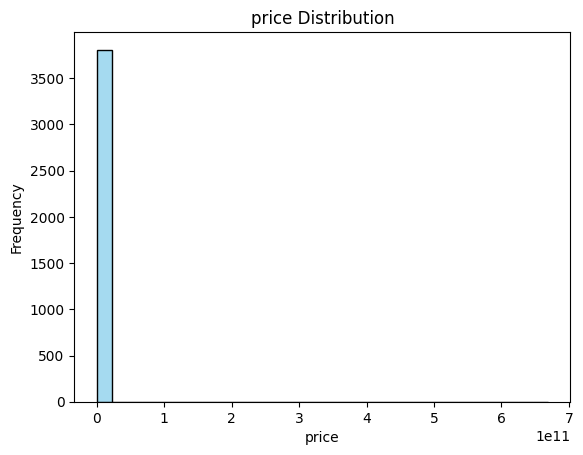

In [134]:
column = 'price'
# Plot the distribution diagram using seaborn
sns.histplot(data=pages_df, x=column,bins=30, color='skyblue')

# Add labels and title
plt.xlabel(column)
plt.ylabel('Frequency')
plt.title('{} Distribution'.format(column))

# Calculate the skewness of the dataset
skewness = skew(pages_df[column])

print("{} Skewness: {}".format(column, skewness))

# Show the plot
plt.show()


The distribution is positively skewed

### b. Distribution diagrams- continuous features

### b1. Bedrooms

Bedrooms Skewness: 0.24401528268680672


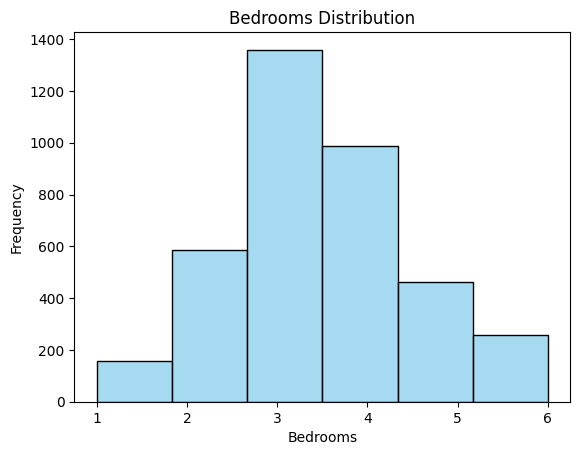

In [135]:
column = 'Bedrooms'
# Plot the distribution diagram using seaborn
sns.histplot(data=pages_df, x=column,bins=6, color='skyblue')

# Add labels and title
plt.xlabel(column)
plt.ylabel('Frequency')
plt.title('{} Distribution'.format(column))

# Calculate the skewness of the dataset
skewness = skew(pages_df[column])

print("{} Skewness: {}".format(column, skewness))

# Show the plot
plt.show()

### b2. Bathrooms

Bathrooms Skewness: 0.7918363700246469


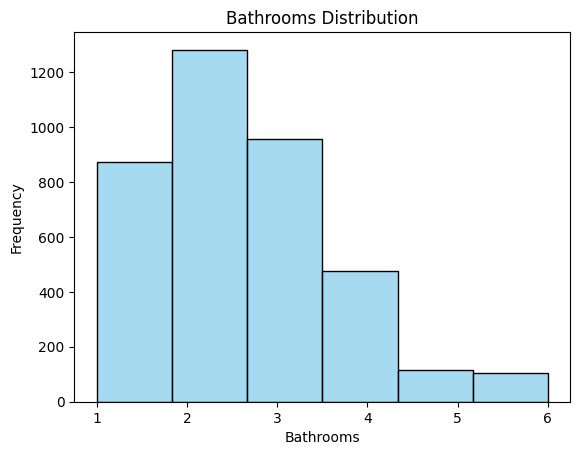

In [136]:
column = 'Bathrooms'
# Plot the distribution diagram using seaborn
sns.histplot(data=pages_df, x=column,bins=6, color='skyblue')

# Add labels and title
plt.xlabel(column)
plt.ylabel('Frequency')
plt.title('{} Distribution'.format(column))

# Calculate the skewness of the dataset
skewness = skew(pages_df[column])

print("{} Skewness: {}".format(column, skewness))

# Show the plot
plt.show()

The distribution is positively skewed

### b3. Size (sqft)

In [137]:
pages_df['Size (sqft)'].describe()

count      470.000000
mean      2061.504255
std       2759.553644
min         13.000000
25%       1077.000000
50%       1500.000000
75%       2146.500000
max      24000.000000
Name: Size (sqft), dtype: float64

In [138]:
column = 'Size (sqft)'

# Plot the histogram using Plotly
fig = px.histogram(pages_df, x=column, nbins=100, color_discrete_sequence=['skyblue'])

# Add labels and title
fig.update_layout(
    xaxis_title=column,
    yaxis_title='Frequency',
    title='{} Distribution'.format(column),
    title_x=0.5
)

# Show the plot
fig.show()

# Calculate the skewness of the dataset
skewness = skew(pages_df[pages_df[column].isna()==False][column])
print("{} Skewness: {}".format(column, skewness))

Size (sqft) Skewness: 6.215610743864625


### c. Distribution diagrams- Categorical features

In [1271]:
pages_df.columns

Index(['url', 'title', 'description', 'attributes', 'location', 'seller',
       'price', 'Bedrooms', 'Size (sqft)', 'Bathrooms', 'region', 'province'],
      dtype='object')

### c1. Seller

In [139]:
pages_df.seller.value_counts()

seller
Professional    3416
Owner            393
Name: count, dtype: int64

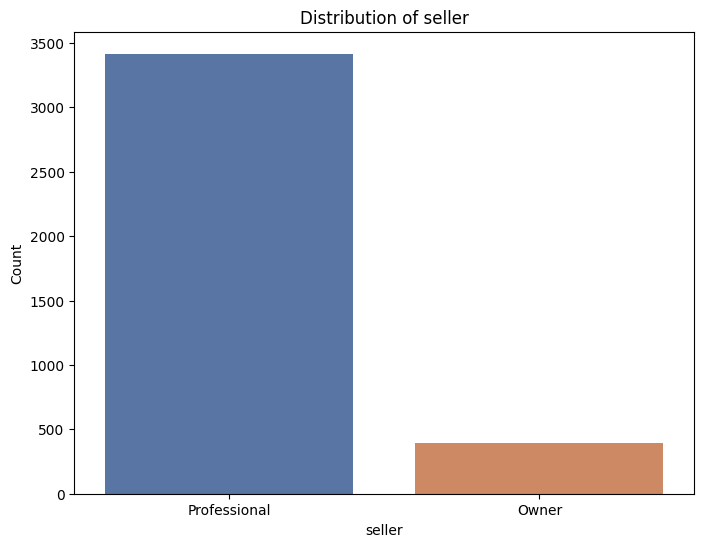

In [140]:
column = 'seller'
# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))  
sns.countplot(data=pages_df, x=column, palette='deep')

# Add labels and title
plt.xlabel(column)
plt.ylabel('Count')
# plt.xticks(rotation=90)
plt.title('Distribution of {}'.format(column))

# Show the plot
plt.show()

Majority of the ads are listed by professionals

### c2. Region

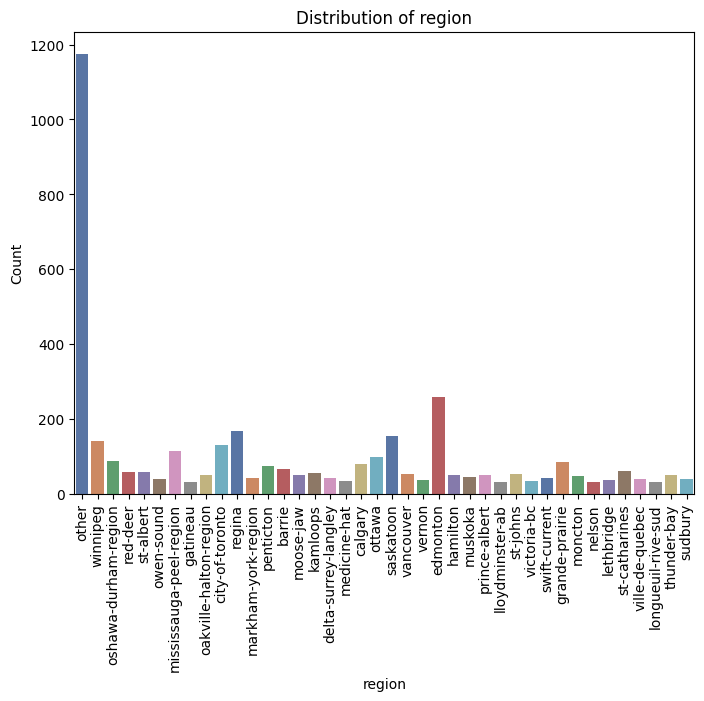

In [141]:
column = 'region'
# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))  
sns.countplot(data=pages_df, x=column, palette='deep')

# Add labels and title
plt.xlabel(column)
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Distribution of {}'.format(column))

# Show the plot
plt.show()

### c3. province

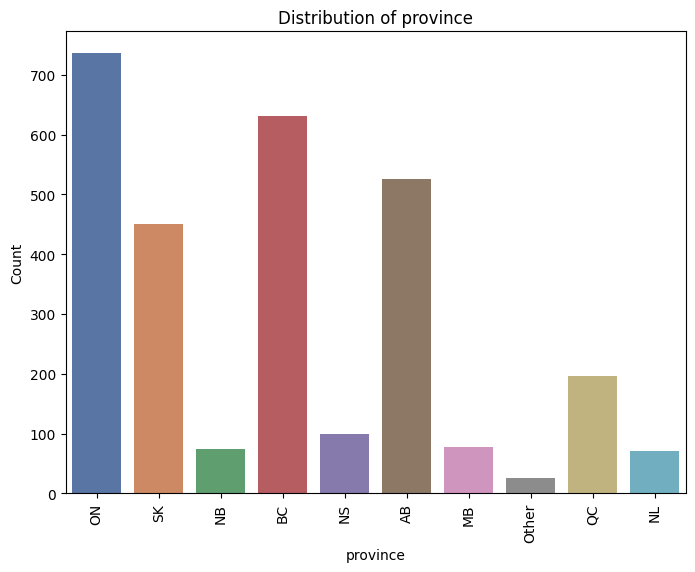

In [142]:
column = 'province'
# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))  
sns.countplot(data=pages_df, x=column, palette='deep')

# Add labels and title
plt.xlabel(column)
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Distribution of {}'.format(column))

# Show the plot
plt.show()

In [143]:
pages_df.columns

Index(['url', 'title', 'description', 'attributes', 'location', 'seller',
       'price', 'Bedrooms', 'Size (sqft)', 'Bathrooms', 'region', 'province'],
      dtype='object')

## 3. Outlier detection and Noise removal

## 3.1 Boxplot-label

Text(0.5, 1.0, 'Box Plot-price')

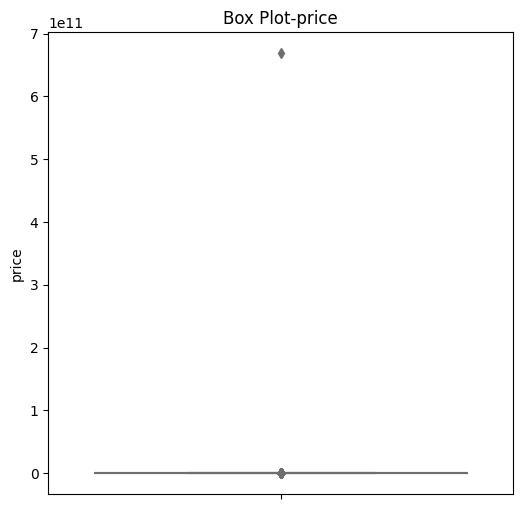

In [144]:
# Create a boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(data=pages_df, y='price', color='skyblue')

# Add labels and title
plt.ylabel('price')
plt.title('Box Plot-price')

# Outliers treatment

### Many of the top 5 percentile cases are noises.  They would be having a major impact on the loss function, and hence the model.  So, they are removed from the dataset


In [145]:
nintyfifth_percentile = pages_df.price.quantile(0.95)
print(nintyfifth_percentile)

2599999.6


In [146]:
# dropping the records with price less than 10000
print("pages_df.shape : before",pages_df.shape)
pages_df = pages_df[(pages_df.price>=10000) & (pages_df.price<=nintyfifth_percentile)]
print("pages_df.shape : after",pages_df.shape)

pages_df.shape : before (3809, 12)
pages_df.shape : after (3615, 12)


Text(0.5, 1.0, 'Box Plot-price after treating outlier')

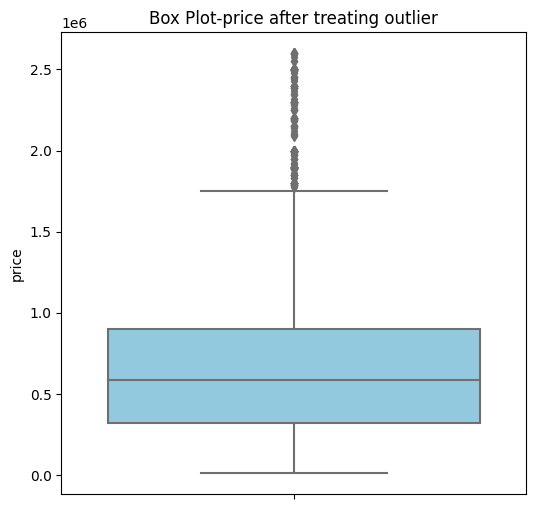

In [147]:
# Create a boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(data=pages_df, y='price', color='skyblue')

# Add labels and title
plt.ylabel('price')
plt.title('Box Plot-price after treating outlier')

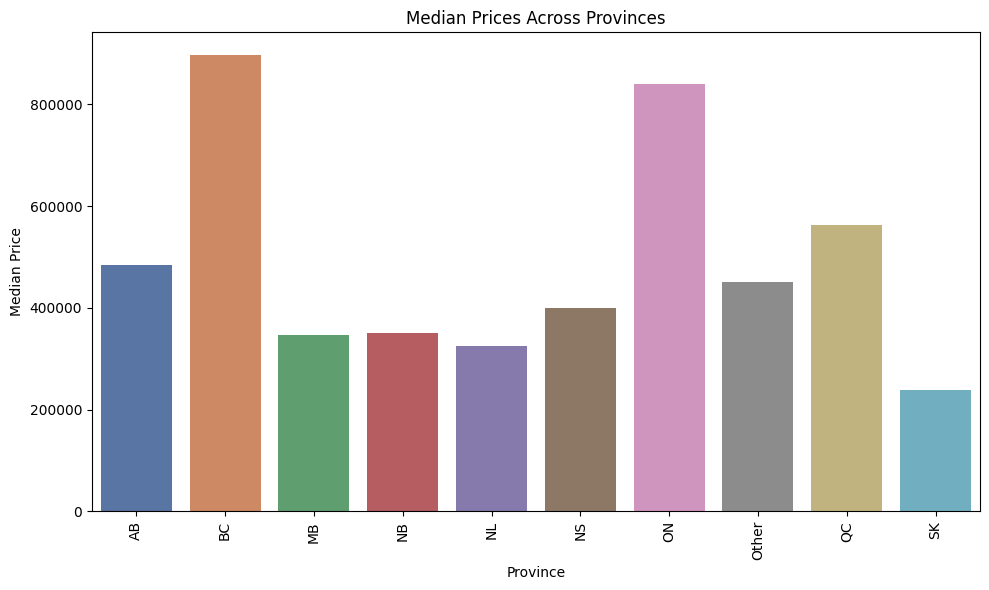

In [148]:
# understanding the price range across the provinces

median_prices = pages_df.groupby(['province'])['price'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=median_prices, x='province', y='price',  palette='deep')
plt.xlabel('Province')
plt.ylabel('Median Price')
plt.title('Median Prices Across Provinces')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

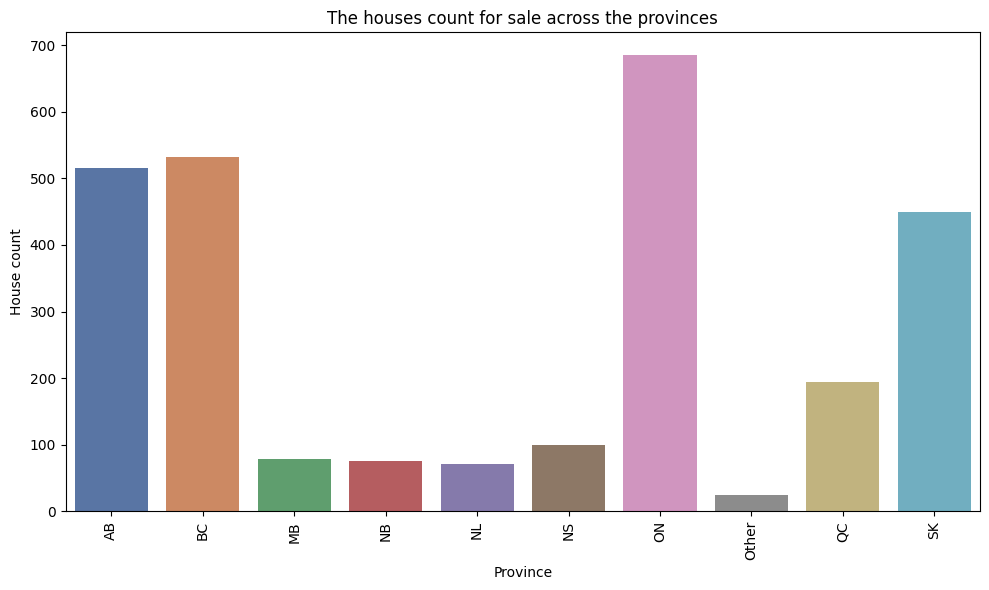

In [149]:
# understanding the count of houses for sale across the provinces

count = pages_df.groupby(['province'])['price'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=count, x='province', y='price',  palette='deep')
plt.xlabel('Province')
plt.ylabel('House count')
plt.title('The houses count for sale across the provinces')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

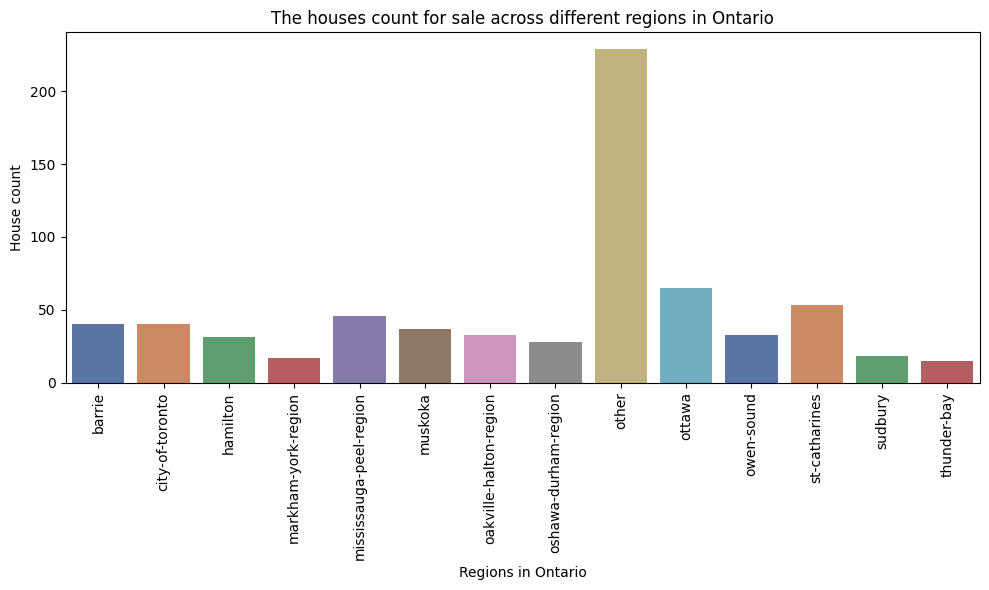

In [150]:
# understanding the count of houses for sale across different regions in Ontario

ontario_df = pages_df[pages_df.province=='ON']
house_count = ontario_df.groupby(['region'])['price'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=house_count, x='region', y='price',  palette='deep')
plt.xlabel('Regions in Ontario')
plt.ylabel('House count')
plt.title('The houses count for sale across different regions in Ontario')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


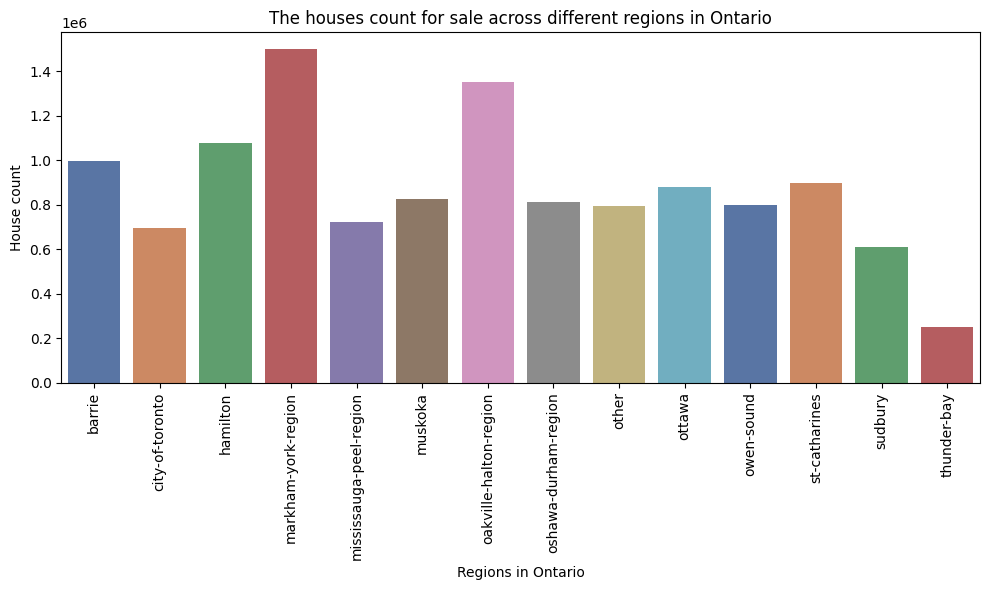

In [151]:
# understanding the count of houses for sale across different regions in Ontario

ontario_df = pages_df[pages_df.province=='ON']
house_count = ontario_df.groupby(['region'])['price'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=house_count, x='region', y='price',  palette='deep')
plt.xlabel('Regions in Ontario')
plt.ylabel('House count')
plt.title('The houses count for sale across different regions in Ontario')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 3.2 Boxplot-features

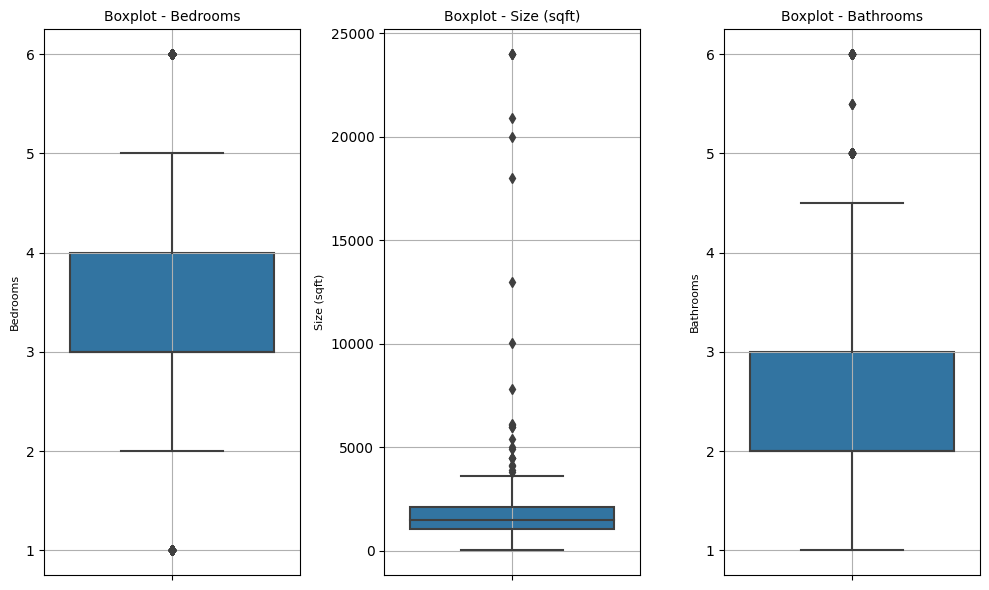

In [152]:
# Create a subplot grid with a 6x6 layout
num_rows = 1
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

# Flatten the 2D array of axes to simplify iteration
axes = axes.flatten()

# Set a single color for all boxplots
plot_color = '#1f77b4'  # Blue color, you can change it to any other valid color code

# Plot boxplots for each feature column
for i, column in enumerate(continuous_features):
    ax = axes[i]
    sns.boxplot(data=pages_df, y=column, ax=ax, color=plot_color)
    ax.set_title(f'Boxplot - {column}', fontsize=10)
    ax.set_ylabel(column, fontsize=8)
    ax.grid(True)

# If there are more axes than columns, remove the extra empty plots
for j in range(len(continuous_features), num_rows * num_cols):
    axes[j].axis('off')


plt.tight_layout()
plt.show()

In [153]:
# Noise-Sqft

In [173]:
pages_df[(pages_df['Size (sqft)'] < 200)]['Size (sqft)']

44    13.0
Name: Size (sqft), dtype: float64

In [174]:
# Handling the records with 'Size (sqft)'<200 as noise, and replacing them with NA values which is to be handled later
pages_df.loc[pages_df['Size (sqft)'] < 200, 'Size (sqft)'] = None
pages_df[(pages_df['Size (sqft)'] < 200)]

Empty DataFrame
Columns: [url, title, description, attributes, location, seller, price, Bedrooms, Size (sqft), Bathrooms, region, province]
Index: []

## 4. Pearson correlation coefficient


Finding the pearson correlation coefficient between the continuous attributes.  Since, it is paramteric, we need to apply normalization over the attributes 

In [175]:
continuous_features = ['Bedrooms', 'Size (sqft)', 'Bathrooms']
continuous_attributes_df = pages_df[continuous_features]


In [176]:
def find_pearson_correlation(X_train_parametric_df,parametric_continuous_features, figsize=(20, 20), threshold_correlation=0.5):

    fig, ax = plt.subplots(figsize=figsize)
    correlation = X_train_parametric_df[parametric_continuous_features].corr()
    sns.heatmap(correlation, annot=False
                , fmt=".2f", cmap="coolwarm")
    plt.title("Pearson correlation coefficient- Heatmap")

    high_correlation_dict = {}

    for column in correlation.columns[2:]:
        correlated_columns = [col for col in correlation[column][(correlation[column] > threshold_correlation) | (correlation[column] < -threshold_correlation)].index.tolist()
                              if col != column]
        if correlated_columns:
            high_correlation_dict[column] = correlated_columns




    return correlation, high_correlation_dict

In [177]:
scaler = MinMaxScaler()

continuous_attributes_df_normalized = pd.DataFrame(scaler.fit_transform(continuous_attributes_df),
                                                   columns=continuous_attributes_df.columns)

(             Bedrooms  Size (sqft)  Bathrooms
 Bedrooms     1.000000     0.318808   0.600981
 Size (sqft)  0.318808     1.000000   0.431802
 Bathrooms    0.600981     0.431802   1.000000,
 {'Bathrooms': ['Bedrooms']})

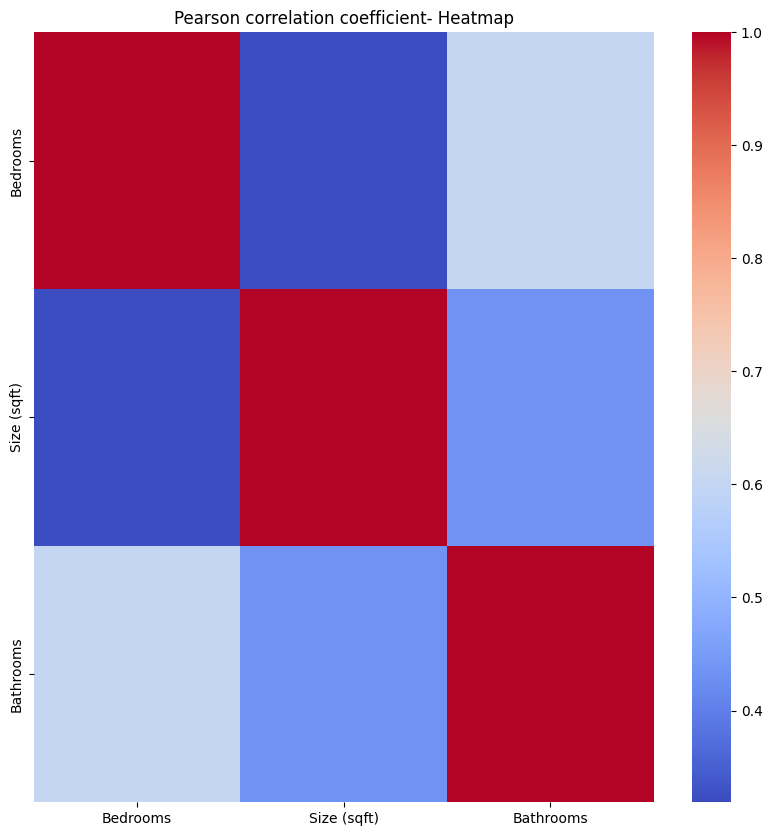

In [178]:
find_pearson_correlation(continuous_attributes_df_normalized,
                         continuous_attributes_df_normalized.columns,
                         figsize=(10, 10),
                         threshold_correlation=0.5)

## Handling Missing values

In [179]:
# checking the percentage of missing values in all columns
pages_df.isna().mean()*100

url             0.000000
title           0.000000
description     0.000000
attributes      0.000000
location       24.591978
seller          0.000000
price           0.000000
Bedrooms        0.000000
Size (sqft)    87.468880
Bathrooms       0.000000
region          0.000000
province       24.591978
dtype: float64

## 1. Size (sqft)

## Information extraction to extract missing attributes from the description


We use regular expression and extractive question answering to extract information from the description


In [1298]:
class QNA():
    def __init__(self):
        model_checkpoint = "consciousAI/question-answering-roberta-base-s-v2"
        
        # load the model
        self.question_answerer = pipeline("question-answering", model=model_checkpoint)

qna_model = QNA()

In [180]:
# Preprocessing description
STOPWORDS = stopwords.words('english')

def preprocess(text):
    
    text = text.lower()
    
    # Define a regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'

    # Use the 're.sub' function to replace URLs with an empty string
    text = re.sub(url_pattern, '', text)

    # Use the 're.sub' function to replace non-alphanumeric characters with an empty string
    cleaned_text = text.translate(str.maketrans('','',string.punctuation))
    
    tokens = cleaned_text.split(' ')
    
    cleaned_text = " ".join([token for token in tokens if token not in STOPWORDS])

    return cleaned_text

pages_df['processed_description'] = pages_df.description.map(preprocess)

/tmp/ipykernel_7389/2830043905.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [181]:
# Quantifying the presence of missing values
pages_df['Size (sqft)'].isna().mean()*100

87.4688796680498

Size in square feet is a potential feature.  But, the majority of the records have missing values in the column.  So, we extract them from the descriptions.

In [607]:
# Using a set of keywords and re to detect if the description has the information regarding square feet

In [182]:
# function to detect the presence of the attribute, square feet
keywords = ['sqft','square feet','square foot','sq.', 'sq foot', 'sq feet','squarefoot',
            'squarefeet', 'square footage',' sf','sq ft','sqr ft','sqrft','ft2','ft²']
keywords = '|'.join(keywords)
keywords = '('+keywords+')'

pattern = r'(\d)*{}'.format(keywords)
print("pattern : ",pattern)



def is_square_feet_present(arg):
    
    matches = re.findall(pattern, arg)
    if matches:
        return True
    return False
        

pattern :  (\d)*(sqft|square feet|square foot|sq.|sq foot|sq feet|squarefoot|squarefeet|square footage| sf|sq ft|sqr ft|sqrft|ft2|ft²)


In [183]:
pages_df['is_square_foot_present'] = pages_df.description.map(is_square_feet_present)
pages_df.is_square_foot_present.value_counts()

/tmp/ipykernel_7389/4232943335.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



is_square_foot_present
False    2562
True     1053
Name: count, dtype: int64

In [33]:
sample_descriptions = pages_df.description[pages_df.is_square_foot_present].tolist()[:5]
sample_descriptions

["Don't miss this water front water access hidden Gem on Lake of the Woods located in Moore bay . Large lot 239ft x 646 ft . Cabin is approximately 1400 sqft includes dock, 2 sheds, riding lawn mower, Honda Generator and all furnishing . Only $ 355,000.00 Seller will carry financing for the right person.\nCall or TXT Dalton 204-471-1144",
 'Beautiful ready to move in 1000 square-foot home .\nLarge city lot with parking for four vehicles.\nHigh-efficiency, gas furnace\nMain floor, laundry hook upsHouse needs paint or siding to bring the outside as nice as the inside.\nAll viewings require 24 hours notice and preferably after 4 PM during the day.\nFor questions or viewing inquiries call John at 613-361-7788',
 'Reduced in asking price Two one bedroom suites that rent for $785 and $750 on the main floor of this bi- level ! On the lower level is a 1200 sq foot commercial suite ideal for many professional uses ! And is currently rented Front office and back storage room and shipping doors !

In [254]:
# Function to extract square feet info using question answering
def extract_sqft_info(context):
    question = 'How many square feet is there for the space precisely?'

    answer = qna_model.question_answerer(question=question, context=context)
    return answer


In [75]:
# Testing the function over sample_descriptions
for description in sample_descriptions:
    print('--------------')
    print('description : ',description)
    print('sqft info : ', extract_sqft_info(description))
    

--------------
description :  Don't miss this water front water access hidden Gem on Lake of the Woods located in Moore bay . Large lot 239ft x 646 ft . Cabin is approximately 1400 sqft includes dock, 2 sheds, riding lawn mower, Honda Generator and all furnishing . Only $ 355,000.00 Seller will carry financing for the right person.
Call or TXT Dalton 204-471-1144
sqft info :  {'score': 0.6760947108268738, 'start': 146, 'end': 155, 'answer': '1400 sqft'}
--------------
description :  Beautiful ready to move in 1000 square-foot home .
Large city lot with parking for four vehicles.
High-efficiency, gas furnace
Main floor, laundry hook upsHouse needs paint or siding to bring the outside as nice as the inside.
All viewings require 24 hours notice and preferably after 4 PM during the day.
For questions or viewing inquiries call John at 613-361-7788
sqft info :  {'score': 0.9202798008918762, 'start': 27, 'end': 31, 'answer': '1000'}
--------------
description :  Reduced in asking price Two on

In [610]:
# Creating a new column to store the square feet information extracted from description
pages_df['sqft_description'] = None


In [7]:
is_square_feet_present_list = pages_df.is_square_foot_present.tolist()
description_list = pages_df.description.tolist()

sqft_description_list = []


for i, description in enumerate(description_list):
    is_square_feet_present_description = is_square_feet_present_list[i]
    
    sqft_description = extract_sqft_info(description) if is_square_feet_present_description else 'NA'
    
    save_path = os.path.join('qna_answers/sqft/','{}.json'.format(primary_key))
    sqft_dict = {
        'description':description,
        'sqft':sqft_description
    }
    
    with open(save_path,'w+') as f:
        json.dump(sqft_dict, f)
    

    

In [184]:
# reading the answers from the files saved locally
save_dir = 'qna_answers/sqft/'

files_list = os.listdir(save_dir)

data_list = []
for file in files_list:
    
    loc = os.path.join(save_dir, file)
    
    with open(loc,'r') as f:
        data = json.load(f)
        data_list.append(data)


In [185]:
sq_ft_df = pd.DataFrame(data_list)
sq_ft_df = sq_ft_df[['description','sqft']]
sq_ft_df

description   
0     MLS® #W6074540\nSpectacular Estate Home Situat...  \
1     MLS® #1344757\nCirca 1850  STONE HOME fully re...   
2     Grand bas de duplex en indivise en plein cœur ...   
3     With our HomeFinder Service you can find your ...   
4     Waterfront GEM with 300ft of Sandy beach along...   
...                                                 ...   
3955  MLS® #R2773120\n* PREC - Personal Real Estate ...   
3956  MLS® #2469801\nThis stunning lakefront home bo...   
3957  Mobile home for sale $35,000\nReady for immedi...   
3958  MLS® #E4325994\nCustom Built home with 3 BEDS,...   
3959  Belle GRANDE TERRE AGRICOLE à Weedon, de +/- 2...   

                                                   sqft  
0                                                    NA  
1                                                    NA  
2     {'score': 0.6573168635368347, 'start': 902, 'e...  
3                                                    NA  
4                                                    NA  
...                                                 ...  
3955                                                 NA  
3956                                                 NA  
3957                                                 NA  
3958                                                 NA  
3959                                                 NA  

[3960 rows x 2 columns]

In [187]:
exceptions_list = []
def typecast_answers(arg):
    if arg=='NA':
        return
    elif type(arg)==str:
        arg = ast.literal_eval(arg)
        return arg
    elif type(arg)==dict:
        return arg
    else:
        exceptions_list.append(arg)
        
        
sq_ft_df['answer'] = sq_ft_df.sqft.map(typecast_answers)
sq_ft_df

description   
0     MLS® #W6074540\nSpectacular Estate Home Situat...  \
1     MLS® #1344757\nCirca 1850  STONE HOME fully re...   
2     Grand bas de duplex en indivise en plein cœur ...   
3     With our HomeFinder Service you can find your ...   
4     Waterfront GEM with 300ft of Sandy beach along...   
...                                                 ...   
3955  MLS® #R2773120\n* PREC - Personal Real Estate ...   
3956  MLS® #2469801\nThis stunning lakefront home bo...   
3957  Mobile home for sale $35,000\nReady for immedi...   
3958  MLS® #E4325994\nCustom Built home with 3 BEDS,...   
3959  Belle GRANDE TERRE AGRICOLE à Weedon, de +/- 2...   

                                                   sqft   
0                                                    NA  \
1                                                    NA   
2     {'score': 0.6573168635368347, 'start': 902, 'e...   
3                                                    NA   
4                                                    NA   
...                                                 ...   
3955                                                 NA   
3956                                                 NA   
3957                                                 NA   
3958                                                 NA   
3959                                                 NA   

                                                 answer  
0                                                  None  
1                                                  None  
2     {'score': 0.6573168635368347, 'start': 902, 'e...  
3                                                  None  
4                                                  None  
...                                                 ...  
3955                                               None  
3956                                               None  
3957                                               None  
3958                                               None  
3959                                               None  

[3960 rows x 3 columns]

In [188]:
def get_answers(arg):
    if type(arg)==dict:
        return arg['answer']
sq_ft_df['answer'] = sq_ft_df.answer.map(get_answers)

In [189]:
sq_ft_df.drop(columns=['sqft'], inplace=True)

In [190]:
sq_ft_df.columns

Index(['description', 'answer'], dtype='object')

In [191]:
sq_ft_df.drop_duplicates(inplace=True)

In [192]:
sq_ft_df.shape

(3907, 2)

In [193]:
pages_df = pages_df.merge(sq_ft_df, on=['description'], how='left')
pages_df.shape

(3615, 15)

In [198]:
def extract_sqft_from_answers(arg):
    noise = "Noise"
    
    if not arg:
        return arg
    
    arg = arg.strip()
    arg = re.sub(r',','',arg)
    arg = re.sub(r'ft(2|²)','sqft',arg)
    
    if not re.findall(r'\d',arg):
        return noise
    
    # To handle cases like '60 000 sqft'
    sqft_split = re.findall(r'(\d+)(\s+)(\d+)', arg)
    if sqft_split and len(sqft_split)==1 and len(sqft_split[0])==3:
        
        sqft = float(re.sub(r'[^.0-9]','',arg))
        
        if sqft<250:
            return noise
        return sqft
    
    
    # To handle cases like '50ft x 60ft'
    sqft_split = re.split(r' x ',arg)
    
    
    
    if len(sqft_split)==2:
        x, y = sqft_split
        
        x = float(re.sub(r'\D','',x))
        y = float(re.sub(r'\D','',y))
        
        
        sqft = x*y
        
        if sqft<250:
            return noise
        return sqft
    elif len(sqft_split)>2:
        return noise
    
    
    # To handle cases like '2500 to 3500 sqft'
    if '-' in arg or 'to' in arg.lower():
        multiple_values = re.findall(r'\d+', arg)
        if len(multiple_values)==2:
            multiple_values = [float(val) for val in multiple_values]
            sqft = np.mean(multiple_values)
            if sqft<250:
                return noise
            return sqft
        elif len(multiple_values)>2:
            return noise
        
    sqft = re.findall(r'\d+',arg)
    
    if len(sqft)!=1:
        return noise
    elif len(sqft[0])>6:
        return noise
    
    sqft = float(sqft[0])
    
    if sqft<250:
        return noise
    
    return sqft

pages_df['sqft_description'] = pages_df.answer.map(extract_sqft_from_answers)
pages_df.head(15)

url   
0   https://www.kijiji.ca/v-house-for-sale/charlot...  \
1   https://www.kijiji.ca/v-house-for-sale/winnipe...   
2   https://www.kijiji.ca/v-house-for-sale/oshawa-...   
3   https://www.kijiji.ca/v-house-for-sale/red-dee...   
4   https://www.kijiji.ca/v-house-for-sale/cornwal...   
5   https://www.kijiji.ca/v-house-for-sale/winnipe...   
6   https://www.kijiji.ca/v-house-for-sale/winnipe...   
7   https://www.kijiji.ca/v-house-for-sale/st-albe...   
8   https://www.kijiji.ca/v-house-for-sale/owen-so...   
9   https://www.kijiji.ca/v-house-for-sale/winnipe...   
10  https://www.kijiji.ca/v-house-for-sale/mississ...   
11  https://www.kijiji.ca/v-house-for-sale/mississ...   
12  https://www.kijiji.ca/v-house-for-sale/mississ...   
13  https://www.kijiji.ca/v-house-for-sale/mississ...   
14  https://www.kijiji.ca/v-house-for-sale/mississ...   

                                                title   
0                     Awesome cottage! Price reduced!  \
1                        Cottage on Lake Of The Woods   
2         4 Bedrooms/3 Baths/ 4 Car Parking/Huge Lot    
3             REDUCED!!! 75 Thompson Cresent Red Deer   
4    House for sale north end of Cornwall 3015 Pit...   
5         Lake life at beautiful Lake of the Prairies   
6   Previous Ventura Show Home in Bonavista FOR SALE!   
7                                          Park model   
8                        3  Bedroom Home in Teeswater   
9        Bi-level triplex ! 1 block east of Henderson   
10  3BR 4WR Detached in Brampton near Chinguacousy...   
11  3BR 4WR Detached in Brampton near Gore Rd And ...   
12  3BR 3WR Detached in Mississauga near Glen Erin...   
13  4BR 4WR Detached in Brampton near Bovaird/Lake...   
14  4BR 4WR Detached in Brampton near Torbram / Fa...   

                                          description   
0   Beautiful winterized cottage minutes to North ...  \
1   Don't miss this water front water access hidde...   
2   Fantastic Opportunity To Own A Fully Detached ...   
3   REDUCED!! House inspection completed in Septem...   
4   Beautiful ready to move in 1000 square-foot ho...   
5   A frame 4 season cottage built 2007. Lakefront...   
6   Welcome to this beautiful 2 storey 1670Sqft ho...   
7   2007 park model with appliances comes with ful...   
8   Excellent commute to Bruce Power\n$499,900\n3 ...   
9   Reduced in asking price Two one bedroom suites...   
10  "3 BR 4 WR Detached in Brampton, near Chinguac...   
11  "3 BR 4 WR Detached in Brampton, near Gore Rd ...   
12  "3 BR 3 WR Detached in Mississauga, near Glen ...   
13  "4 BR 4 WR Detached in Brampton, near Bovaird/...   
14  "4 BR 4 WR Detached in Brampton, near Torbram ...   

                                           attributes location        seller   
0                 {'Bedrooms': '2', 'Bathrooms': '1'}      NaN  Professional  \
1   {'Bedrooms': '4', 'Bathrooms': '1', 'Size (sqf...      NaN  Professional   
2                 {'Bedrooms': '4', 'Bathrooms': '3'}      NaN  Professional   
3   {'Bedrooms': '5', 'Bathrooms': '3', 'Size (sqf...      NaN         Owner   
4   {'Bedrooms': '2', 'Bathrooms': '1', 'Size (sqf...      NaN         Owner   
5   {'Bedrooms': '3', 'Bathrooms': '2', 'Size (sqf...      NaN         Owner   
6   {'Bedrooms': '4', 'Bathrooms': '3', 'Size (sqf...      NaN  Professional   
7   {'Bedrooms': '1', 'Bathrooms': '1', 'Size (sqf...      NaN         Owner   
8   {'Bedrooms': '3', 'Bathrooms': '2', 'Size (sqf...      NaN  Professional   
9   {'Bedrooms': '2', 'Bathrooms': '3', 'Size (sqf...      NaN  Professional   
10                {'Bedrooms': '3', 'Bathrooms': '4'}      NaN  Professional   
11                {'Bedrooms': '3', 'Bathrooms': '4'}      NaN  Professional   
12                {'Bedrooms': '3', 'Bathrooms': '3'}      NaN  Professional   
13                {'Bedrooms': '4', 'Bathrooms': '4'}      NaN  Professional   
14                {'Bedrooms': '4', 'Bathrooms': '4'}      NaN  Professional   

        price  Bedrooms  Size 

In [211]:
noises = pages_df.answer[pages_df.sqft_description=='Noise'].tolist()
noises

['Main floor is a 1 bedroom suite and can have basement as extra sq footage',
 '12',
 '1/2',
 '5',
 '4200pi2',
 '204-298-0889',
 'Bright open plan',
 '4',
 '50x120 sqft',
 '4',
 'four',
 '10',
 '2',
 '\xa0',
 '2',
 '4',
 '4',
 'plenty of space.  The garage enthusiast will appreciated the  22x33',
 '35',
 '100',
 '4',
 '6703776',
 '72',
 '2300.92 sq ft',
 '170',
 '100',
 '100',
 '202310475',
 '1257523',
 '26',
 '1254638\n',
 '2053149',
 '1528 sqft + 270 sqft',
 '1528 sqft + 270 sqft',
 '2',
 '2 x 2',
 '80-100',
 '4159625',
 '26',
 '10.5 acres',
 'six',
 '100',
 '501.54',
 '9 foot ceilings',
 '10275921',
 'two',
 '\nFair Realty\n',
 '202310499',
 '14',
 'Room sizes are approximate',
 '2772142',
 '24',
 '15',
 '200',
 '9081462',
 '16170818',
 '24895537',
 '237',
 '4343057\n',
 'basement as extra sq footage',
 '10273036',
 '6701622',
 '1.5',
 'One',
 '40428573',
 '893.84',
 '2',
 '10x12',
 '93',
 '5',
 '4338163',
 '2773241\n',
 '\tCentral air\n',
 '581-989-2601',
 'Room sizes are approxima

In [212]:
pages_df.sqft_description.replace({'Noise':None},inplace=True)

In [213]:
# Converting into float
pages_df.sqft_description = pages_df.sqft_description.astype(float)

In [214]:
pages_df['Size (sqft)'].isna().mean()

0.8746887966804979

In [215]:
pages_df.loc[pages_df['Size (sqft)'].isna(), 'Size (sqft)'] = pages_df.loc[pages_df['Size (sqft)'].isna(), 'sqft_description']
pages_df['Size (sqft)'].isna().mean()

0.6525587828492393

### The percentage of missing values is reduced to 64 percent 

In [216]:
ninetynineth_percentile = pages_df['Size (sqft)'].quantile(0.99)
ninetynineth_percentile

55636.10000000016

Text(0.5, 1.0, 'Box Plot-Size (sqft) Before treating outlier')

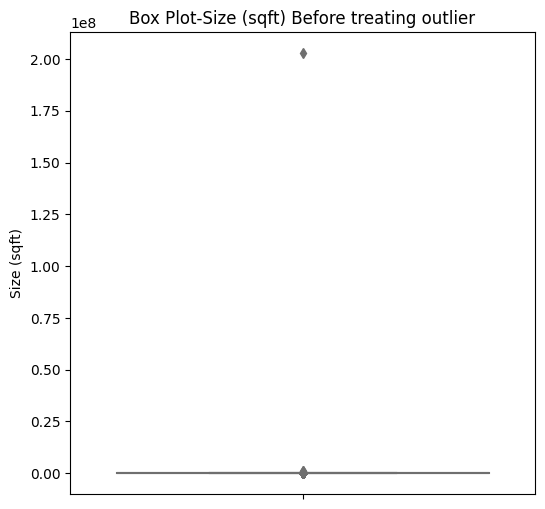

In [217]:
# Create a boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(data=pages_df, y='Size (sqft)', color='skyblue')

# Add labels and title
plt.ylabel('Size (sqft)')
plt.title('Box Plot-Size (sqft) Before treating outlier')

In [218]:
# Applying Capping to the values greater than 99 percentile
pages_df['Size (sqft)'][pages_df['Size (sqft)']>ninetynineth_percentile] = ninetynineth_percentile

/tmp/ipykernel_7389/3214212488.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Box Plot-Size (sqft) After treating outlier')

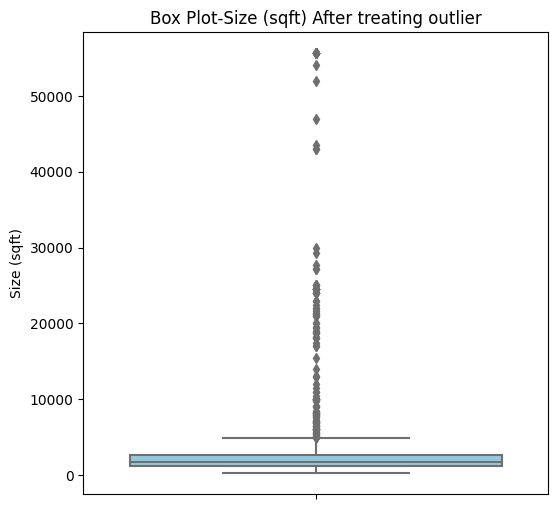

In [219]:
# Create a boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(data=pages_df, y='Size (sqft)', color='skyblue')

# Add labels and title
plt.ylabel('Size (sqft)')
plt.title('Box Plot-Size (sqft) After treating outlier')

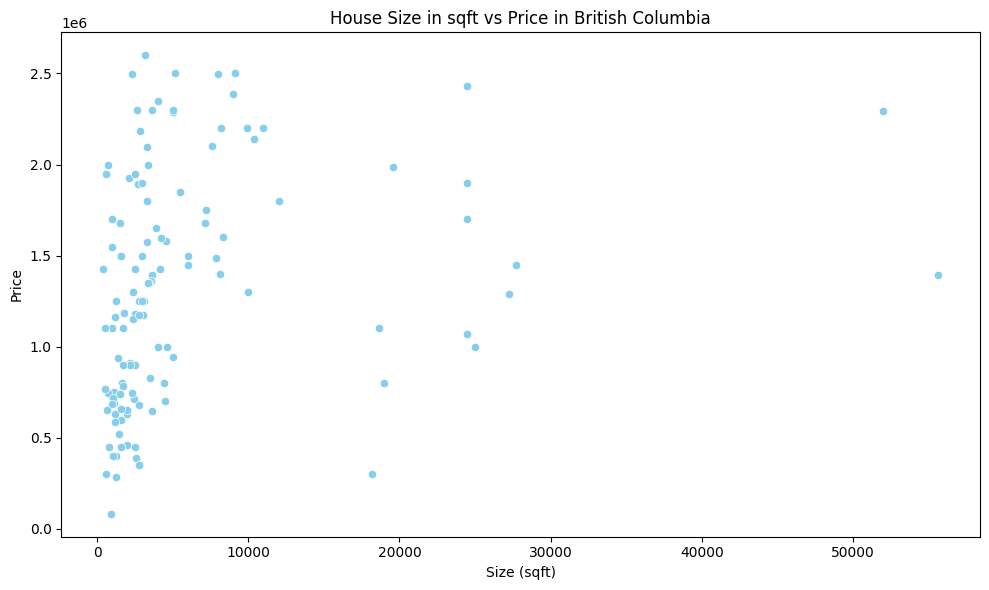

In [220]:
# Plotting House size in sqft vs Price in BC
plt.figure(figsize=(10, 6))
bc_df = pages_df[pages_df.province=='BC']
sns.scatterplot(data=bc_df, x='Size (sqft)', y='price', color='skyblue')
plt.xlabel('Size (sqft)')
plt.ylabel('Price')
plt.title('House Size in sqft vs Price in British Columbia')
plt.tight_layout()
plt.show()

In [221]:
# Finding the median value of 'Size (sqft)'for the corresponding Bedrooms and Bathrooms, to impute the missing values.

In [222]:
median_size_df = pages_df.groupby(['Bedrooms','Bathrooms'])['Size (sqft)'].median().reset_index()
median_size_df

Bedrooms  Bathrooms  Size (sqft)
0          1        1.0       782.00
1          1        1.5          NaN
2          1        2.0      1400.00
3          1        3.0      4990.00
4          2        1.0       950.00
5          2        1.5      1176.00
6          2        2.0      1284.00
7          2        2.5      2304.00
8          2        3.0      1306.50
9          2        3.5      1686.00
10         2        4.0      1162.50
11         3        1.0      1176.00
12         3        1.5      1230.00
13         3        2.0      1512.00
14         3        2.5      1877.50
15         3        3.0      1767.50
16         3        3.5      1834.50
17         3        4.0      2133.50
18         3        5.0      3000.00
19         4        1.0      1360.00
20         4        1.5     13950.00
21         4        2.0      1671.00
22         4        2.5      2041.50
23         4        3.0      1994.00
24         4        3.5      2200.00
25         4        4.0      2550.00
26         4        5.0      3443.00
27         4        6.0      4500.00
28         5        1.0       864.00
29         5        1.5      3000.00
30         5        2.0      1675.00
31         5        2.5      2133.00
32         5        3.0      2650.00
33         5        3.5      2805.50
34         5        4.0      3367.00
35         5        5.0      4381.50
36         5        5.5          NaN
37         5        6.0      5000.00
38         6        1.0     28418.05
39         6        1.5          NaN
40         6        2.0      1060.00
41         6        2.5      1049.00
42         6        3.0      3219.00
43         6        3.5      3616.00
44         6        4.0      2787.00
45         6        4.5       560.00
46         6        5.0      4100.00
47         6        5.5      3653.00
48         6        6.0      6122.50

In [223]:
# Impute missing values using the mean of preceding and succeeding values
missing_indices = median_size_df[median_size_df['Size (sqft)'].isnull()].index
for index in missing_indices:
    prev_index = index - 1
    next_index = index + 1
    if prev_index >= 0 and next_index < len(pages_df):
        imputed_value = (median_size_df.loc[prev_index, 'Size (sqft)'] + median_size_df.loc[next_index, 'Size (sqft)']) / 2
        median_size_df.loc[index, 'Size (sqft)'] = imputed_value

In [224]:
median_size_df

Bedrooms  Bathrooms  Size (sqft)
0          1        1.0      782.000
1          1        1.5     1091.000
2          1        2.0     1400.000
3          1        3.0     4990.000
4          2        1.0      950.000
5          2        1.5     1176.000
6          2        2.0     1284.000
7          2        2.5     2304.000
8          2        3.0     1306.500
9          2        3.5     1686.000
10         2        4.0     1162.500
11         3        1.0     1176.000
12         3        1.5     1230.000
13         3        2.0     1512.000
14         3        2.5     1877.500
15         3        3.0     1767.500
16         3        3.5     1834.500
17         3        4.0     2133.500
18         3        5.0     3000.000
19         4        1.0     1360.000
20         4        1.5    13950.000
21         4        2.0     1671.000
22         4        2.5     2041.500
23         4        3.0     1994.000
24         4        3.5     2200.000
25         4        4.0     2550.000
26         4        5.0     3443.000
27         4        6.0     4500.000
28         5        1.0      864.000
29         5        1.5     3000.000
30         5        2.0     1675.000
31         5        2.5     2133.000
32         5        3.0     2650.000
33         5        3.5     2805.500
34         5        4.0     3367.000
35         5        5.0     4381.500
36         5        5.5     4690.750
37         5        6.0     5000.000
38         6        1.0    28418.050
39         6        1.5    14739.025
40         6        2.0     1060.000
41         6        2.5     1049.000
42         6        3.0     3219.000
43         6        3.5     3616.000
44         6        4.0     2787.000
45         6        4.5      560.000
46         6        5.0     4100.000
47         6        5.5     3653.000
48         6        6.0     6122.500

In [225]:
def get_median_size_ft2(arg):
    
    bedroom, bathroom = arg
    median = median_size_df[(median_size_df.Bedrooms==bedroom) &(median_size_df.Bathrooms==bathroom)]['Size (sqft)']
    median = median.tolist()[0]
    return median

get_median_size_ft2(arg=(6,6))

6122.5

In [226]:
pages_df.columns

Index(['url', 'title', 'description', 'attributes', 'location', 'seller',
       'price', 'Bedrooms', 'Size (sqft)', 'Bathrooms', 'region', 'province',
       'processed_description', 'is_square_foot_present', 'answer',
       'sqft_description'],
      dtype='object')

In [227]:
pages_df["bedroom_bathroom"] = list(zip(pages_df.Bedrooms, pages_df.Bathrooms))
pages_df["NA_replacement"] = pages_df.bedroom_bathroom.map(get_median_size_ft2)

pages_df['Size (sqft)'][pages_df['Size (sqft)'].isna()] = pages_df["NA_replacement"][pages_df['Size (sqft)'].isna()]


/tmp/ipykernel_7389/2985292105.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [228]:
pages_df['Size (sqft)'].isna().mean()*100

0.0

### The missing values are reduced to 0 percent

## 2. Province

In [229]:
pages_df.province.isna().mean()*100

24.591977869986167

In [230]:
pages_df[pages_df.province.isna()]

url   
0     https://www.kijiji.ca/v-house-for-sale/charlot...  \
1     https://www.kijiji.ca/v-house-for-sale/winnipe...   
2     https://www.kijiji.ca/v-house-for-sale/oshawa-...   
3     https://www.kijiji.ca/v-house-for-sale/red-dee...   
4     https://www.kijiji.ca/v-house-for-sale/cornwal...   
...                                                 ...   
3462  https://www.kijiji.ca/v-maison-a-vendre/longue...   
3463  https://www.kijiji.ca/v-house-for-sale/delta-s...   
3464  https://www.kijiji.ca/v-house-for-sale/vernon/...   
3465  https://www.kijiji.ca/v-house-for-sale/edmonto...   
3466  https://www.kijiji.ca/v-house-for-sale/city-of...   

                                                  title   
0                       Awesome cottage! Price reduced!  \
1                          Cottage on Lake Of The Woods   
2           4 Bedrooms/3 Baths/ 4 Car Parking/Huge Lot    
3               REDUCED!!! 75 Thompson Cresent Red Deer   
4      House for sale north end of Cornwall 3015 Pit...   
...                                                 ...   
3462                                Duplex à Huntingdon   
3463               Triple car garage Townhouse for sale   
3464                          Welcome to your new home!   
3465                               House Sale - Private   
3466           VMC M2 Towns 3 Beds Townhouse Assginment   

                                            description   
0     Beautiful winterized cottage minutes to North ...  \
1     Don't miss this water front water access hidde...   
2     Fantastic Opportunity To Own A Fully Detached ...   
3     REDUCED!! House inspection completed in Septem...   
4     Beautiful ready to move in 1000 square-foot ho...   
...                                                 ...   
3462  Huntingdon, dans le village. Duplex à être ent...   
3463  Looking for a fantastic 3bdrm/3bath End Unit t...   
3464  The main floor boasts a bright and open living...   
3465  Welcome to One At Keswick--a neighborhood boas...   
3466  M2 Towns at the heart of Vaughan VMC.\n- 3 Bed...   

                                             attributes location   
0                   {'Bedrooms': '2', 'Bathrooms': '1'}      NaN  \
1     {'Bedrooms': '4', 'Bathrooms': '1', 'Size (sqf...      NaN   
2                   {'Bedrooms': '4', 'Bathrooms': '3'}      NaN   
3     {'Bedrooms': '5', 'Bathrooms': '3', 'Size (sqf...      NaN   
4     {'Bedrooms': '2', 'Bathrooms': '1', 'Size (sqf...      NaN   
...                                                 ...      ...   
3462  {'Chambres à coucher': '6 chambres ou plus', '...      NaN   
3463  {'Bedrooms': '3', 'Bathrooms': '3', 'Size (sqf...      NaN   
3464  {'Bedrooms': '4', 'Bathrooms': '3', 'Size (sqf...      NaN   
3465  {'Bedrooms': '4', 'Bathrooms': '3', 'Size (sqf...      NaN   
3466  {'Bedrooms': '3', 'Bathrooms': '3', 'Size (sqf...      NaN   

            seller      price  Bedrooms  Size (sqft)  Bathrooms   
0     Professional   309900.0         2        950.0        1.0  \
1     Professional   355000.0         4       1400.0        1.0   
2     Professional   725000.0         4       1994.0        3.0   
3            Owner   535000.0         5       1343.0        3.0   
4            Owner   269000.0         2       1000.0        1.0   
...            ...        ...       ...          ...        ...   
3462  Professional   170000.0         6       1060.0        2.0   
3463  Professional   899800.0         3       1541.0        3.0   
3464  Professional   624900.0         4       1899.0        3.0   
3465         Owner   490000.0         4       1780.0        3.0   
3466         Owner  1169900.0         3       1567.0        3.0   

                    region province   
0                    other      NaN  \
1                 winnipeg      NaN   
2     oshawa-durham-region      NaN   
3                 red-deer      NaN   
4                    other      NaN   
...                    ...      ...   
3462    longueuil-rive-sud    

In [1353]:
# using the values in the column, region to impute the missing values of province

In [231]:
region_to_province = {
    'edmonton': 'AB',
    'regina': 'SK',
    'saskatoon': 'SK',
    'winnipeg': 'MB',
    'city-of-toronto': 'ON',
    'mississauga-peel-region': 'ON',
    'ottawa': 'ON',
    'oshawa-durham-region': 'ON',
    'grande-prairie': 'AB',
    'calgary': 'AB',
    'penticton': 'BC',
    'barrie': 'ON',
    'st-catharines': 'ON',
    'st-albert': 'AB',
    'red-deer': 'AB',
    'kamloops': 'BC',
    'st-johns': 'NL',
    'vancouver': 'BC',
    'hamilton': 'ON',
    'oakville-halton-region': 'ON',
    'moose-jaw': 'SK',
    'prince-albert': 'SK',
    'thunder-bay': 'ON',
    'moncton': 'NB',
    'muskoka': 'ON',
    'swift-current': 'SK',
    'delta-surrey-langley': 'BC',
    'markham-york-region': 'ON',
    'sudbury': 'ON',
    'owen-sound': 'ON',
    'ville-de-quebec': 'QC',
    'lethbridge': 'AB',
    'vernon': 'BC',
    'victoria-bc': 'BC',
    'medicine-hat': 'AB',
    'lloydminster-ab': 'AB',
    'longueuil-rive-sud': 'QC',
    'nelson': 'BC',
    'gatineau': 'QC'
}
region_to_province

{'edmonton': 'AB',
 'regina': 'SK',
 'saskatoon': 'SK',
 'winnipeg': 'MB',
 'city-of-toronto': 'ON',
 'mississauga-peel-region': 'ON',
 'ottawa': 'ON',
 'oshawa-durham-region': 'ON',
 'grande-prairie': 'AB',
 'calgary': 'AB',
 'penticton': 'BC',
 'barrie': 'ON',
 'st-catharines': 'ON',
 'st-albert': 'AB',
 'red-deer': 'AB',
 'kamloops': 'BC',
 'st-johns': 'NL',
 'vancouver': 'BC',
 'hamilton': 'ON',
 'oakville-halton-region': 'ON',
 'moose-jaw': 'SK',
 'prince-albert': 'SK',
 'thunder-bay': 'ON',
 'moncton': 'NB',
 'muskoka': 'ON',
 'swift-current': 'SK',
 'delta-surrey-langley': 'BC',
 'markham-york-region': 'ON',
 'sudbury': 'ON',
 'owen-sound': 'ON',
 'ville-de-quebec': 'QC',
 'lethbridge': 'AB',
 'vernon': 'BC',
 'victoria-bc': 'BC',
 'medicine-hat': 'AB',
 'lloydminster-ab': 'AB',
 'longueuil-rive-sud': 'QC',
 'nelson': 'BC',
 'gatineau': 'QC'}

In [232]:
missing_regions = pages_df['province'].isna()
pages_df.loc[missing_regions, 'province'] = pages_df.loc[missing_regions, 'region'].map(region_to_province)

In [233]:
pages_df.province.isna().mean()

0.06417704011065006

In [234]:
# replacing the remaining missing values using mode
province_mode = pages_df.province.mode().item()
print('province_mode : ',province_mode)
pages_df.province.fillna(province_mode, inplace=True)

province_mode :  ON


In [235]:
pages_df.province.isna().mean()

0.0

In [1360]:
pages_df = pages_df[['seller', 'Bedrooms', 'Size (sqft)', 'Bathrooms', 'region', 'province','price']]

## Word cloud on the description

In [239]:
processed_text = ' '.join(pages_df.processed_description.tolist())

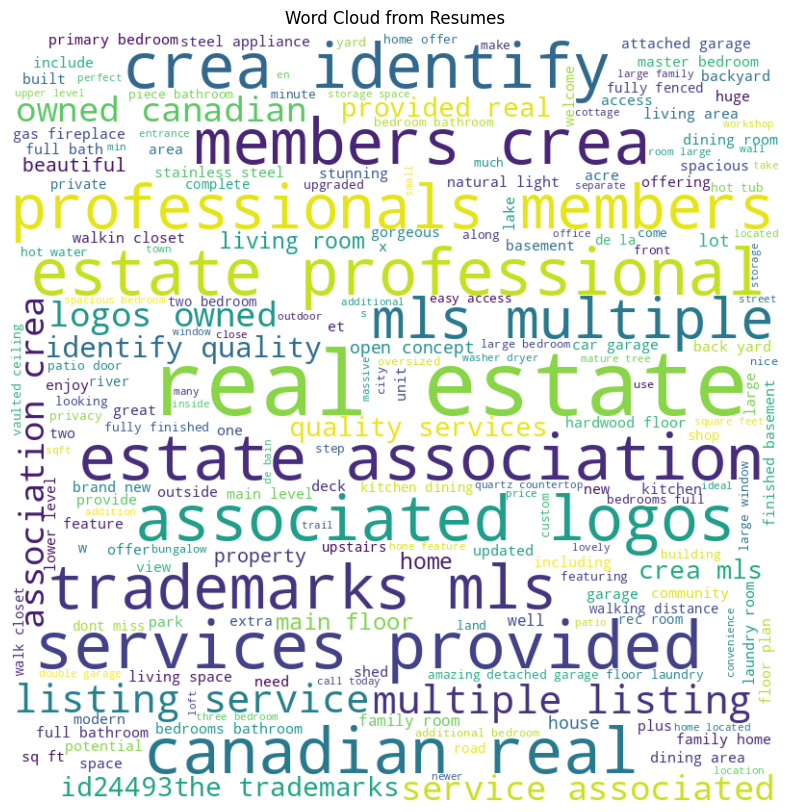

In [242]:
# Create a WordCloud object with customized settings
wordcloud = WordCloud(
    width=800,                   # Width of the word cloud image
    height=800,                  # Height of the word cloud image
    background_color='white',    # Background color of the image
    colormap='viridis',          # Colormap for coloring the words
    collocations=True,           # Include collocations (words that frequently appear together)
    contour_color='steelblue',   # Color of the contour lines around the words
    contour_width=2,             # Width of the contour lines
    max_words=200,               # Maximum number of words to include in the word cloud
    stopwords=None              # List of words to exclude from the word cloud
)

# Generate the word cloud from the processed text
wordcloud.generate(processed_text)

# Display the generated Word Cloud using Matplotlib
plt.figure(figsize=(10, 10))   # Set the size of the figure
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")                # Turn off the axis
plt.title("Word Cloud from Resumes")  # Title for the word cloud
plt.show()

In [244]:
# Dropping unnecessary columns
columns_to_drop = [ 'location','processed_description', 'is_square_foot_present', 'answer',
                   'sqft_description', 'bedroom_bathroom', 'NA_replacement',
                  'url', 'title', 'description', 'attributes']
pages_df.drop(columns=columns_to_drop, inplace=True)

In [248]:
pages_df.columns

Index(['seller', 'price', 'Bedrooms', 'Size (sqft)', 'Bathrooms', 'region',
       'province'],
      dtype='object')

# Label Encoding

In [249]:
encoded_df = pd.get_dummies(pages_df, columns=['seller', 'region', 'province'])
encoded_df.head()


price  Bedrooms  Size (sqft)  Bathrooms  seller_Owner   
0  309900.0         2        950.0        1.0         False  \
1  355000.0         4       1400.0        1.0         False   
2  725000.0         4       1994.0        3.0         False   
3  535000.0         5       1343.0        3.0          True   
4  269000.0         2       1000.0        1.0          True   

   seller_Professional  region_barrie  region_calgary  region_city-of-toronto   
0                 True          False           False                   False  \
1                 True          False           False                   False   
2                 True          False           False                   False   
3                False          False           False                   False   
4                False          False           False                   False   

   region_delta-surrey-langley  ...  province_AB  province_BC  province_MB   
0                        False  ...        False        False        False  \
1                        False  ...        False        False         True   
2                        False  ...        False        False        False   
3                        False  ...         True        False        False   
4                        False  ...        False        False        False   

   province_NB  province_NL  province_NS  province_ON  province_Other   
0        False        False        False         True           False  \
1        False        False        False        False           False   
2        False        False        False         True           False   
3        False        False        False        False           False   
4        False        False        False         True           False   

   province_QC  province_SK  
0        False        False  
1        False        False  
2        False        False  
3        False        False  
4        False        False  

[5 rows x 56 columns]

In [250]:
encoded_df.columns

Index(['price', 'Bedrooms', 'Size (sqft)', 'Bathrooms', 'seller_Owner',
       'seller_Professional', 'region_barrie', 'region_calgary',
       'region_city-of-toronto', 'region_delta-surrey-langley',
       'region_edmonton', 'region_gatineau', 'region_grande-prairie',
       'region_hamilton', 'region_kamloops', 'region_lethbridge',
       'region_lloydminster-ab', 'region_longueuil-rive-sud',
       'region_markham-york-region', 'region_medicine-hat',
       'region_mississauga-peel-region', 'region_moncton', 'region_moose-jaw',
       'region_muskoka', 'region_nelson', 'region_oakville-halton-region',
       'region_oshawa-durham-region', 'region_other', 'region_ottawa',
       'region_owen-sound', 'region_penticton', 'region_prince-albert',
       'region_red-deer', 'region_regina', 'region_saskatoon',
       'region_st-albert', 'region_st-catharines', 'region_st-johns',
       'region_sudbury', 'region_swift-current', 'region_thunder-bay',
       'region_vancouver', 'region_verno

In [251]:
# Dropping columns to avoid reduntancy

columns_to_drop = ['seller_Professional','region_other','province_Other']

encoded_df.drop(columns=columns_to_drop, inplace=True)

# Calculation of Feature Importance using Random Forest

In [252]:
def feature_importance(df, label_name, method = "random_forest"):

    if not method:
        print("Enter valid method to find feature importance")
        return

    if method=="random_forest":
        X = df.drop([label_name], axis=1)  # remove target column from features
        y = df[label_name]

        rf = RandomForestRegressor(n_estimators=5, random_state=42)
        rf.fit(X, y)

        # get feature importances from the model
        importances = rf.feature_importances_

        # sort the features by importance in descending order
        sorted_idx = importances.argsort()[::-1]

        # plot the feature importances
        fig, ax = plt.subplots(figsize=(20, 20))

        plt.bar(range(X.shape[1]), importances[sorted_idx])
        plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=90)
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.title('Feature Importance')
        plt.show()

        return X.columns[sorted_idx]

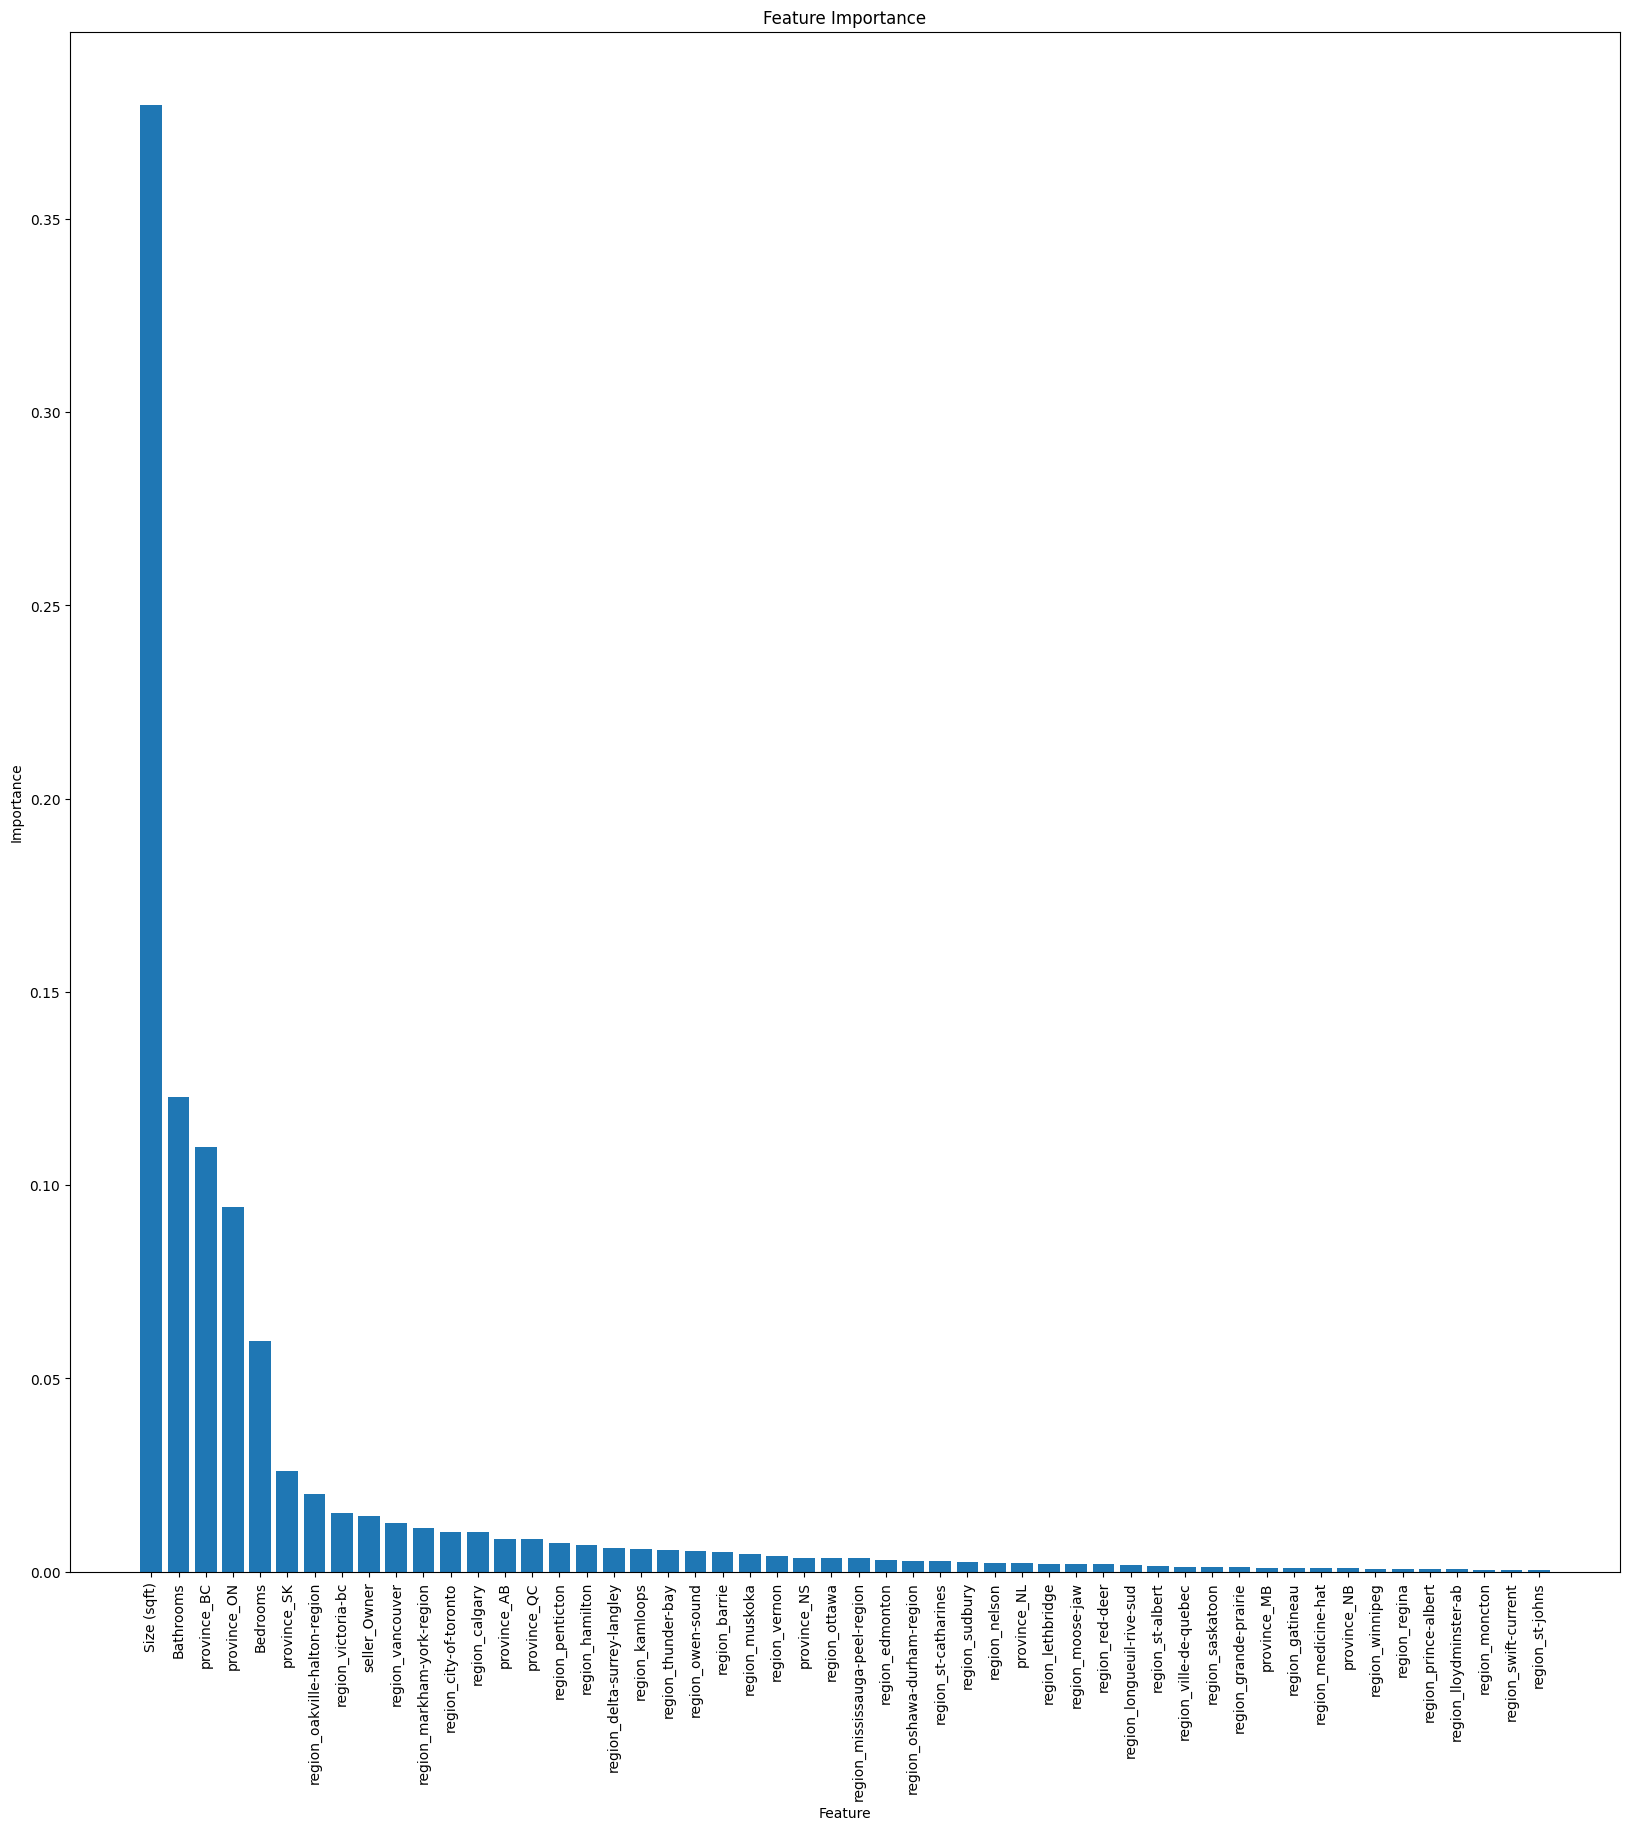

Index(['Size (sqft)', 'Bathrooms', 'province_BC', 'province_ON', 'Bedrooms',
       'province_SK', 'region_oakville-halton-region', 'region_victoria-bc',
       'seller_Owner', 'region_vancouver', 'region_markham-york-region',
       'region_city-of-toronto', 'region_calgary', 'province_AB',
       'province_QC', 'region_penticton', 'region_hamilton',
       'region_delta-surrey-langley', 'region_kamloops', 'region_thunder-bay',
       'region_owen-sound', 'region_barrie', 'region_muskoka', 'region_vernon',
       'province_NS', 'region_ottawa', 'region_mississauga-peel-region',
       'region_edmonton', 'region_oshawa-durham-region',
       'region_st-catharines', 'region_sudbury', 'region_nelson',
       'province_NL', 'region_lethbridge', 'region_moose-jaw',
       'region_red-deer', 'region_longueuil-rive-sud', 'region_st-albert',
       'region_ville-de-quebec', 'region_saskatoon', 'region_grande-prairie',
       'province_MB', 'region_gatineau', 'region_medicine-hat', 'province_N

In [253]:
feature_importance(encoded_df, label_name='price')

# Model Training

In [254]:
def run_train_test_split(df, label_name, test_ratio=0.3):
    X = df.drop([label_name], axis=1)
    y = df[label_name]
    
    # Splitting the data into train/test features and label
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=test_ratio, random_state=42)

    # Print the shapes of the training and testing sets
    print('Training set shape:', X_train_df.shape, y_train_df.shape)
    print('Testing set shape:', X_test_df.shape, y_test_df.shape)

    return X_train_df, X_test_df, y_train_df, y_test_df

In [273]:
def train_test(regressor, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=48)
    regressor.fit(X_train, y_train)
    
    train_r2 = regressor.score(X_train, y_train)
    test_r2 = regressor.score(X_test, y_test)
    
    print("Train r2 score: {}, Test MSE r2 score: {}".format(train_r2, test_r2))
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print("Train MAE: {:.2f}, Test MAE: {:.2f}".format(train_mae, test_mae))

    print("Train MSE: {}, Test MSE: {}".format(train_mse, test_mse))
    
    return train_mae, test_mae, regressor

    

In [256]:
X = encoded_df.drop(columns=['price'])
y = encoded_df['price']

In [298]:
models_info_dict_list = []

In [299]:
# Trial 1- Random Forest with default configuration

In [300]:
trial1 = Pipeline([
    ("regressor", RandomForestRegressor(random_state=0))
])

train_mae, test_mae, clf = train_test(trial1, X, y)
models_info_dict_list.append({'model_id':'trial1',
                             'train_mae':train_mae,
                              'test_mae':test_mae
                             })

Train r2 score: 0.789389884034875, Test MSE r2 score: 0.5018596505078146
Train MAE: 144515.75, Test MAE: 235913.52
Train MSE: 53186128959.48055, Test MSE: 121986453902.28421


In [301]:
# Trial 2- PCA with 95 percent variance + Random Forest with default configuration

In [302]:
trial2 = Pipeline([
    ("pca", PCA(n_components=0.95)),  # Add PCA with 95% explained variance
    ("regressor", RandomForestRegressor(random_state=0))
])

train_mae, test_mae, clf = train_test(trial2, X, y)

models_info_dict_list.append({'model_id':'trial2',
                             'train_mae':train_mae,
                              'test_mae':test_mae
                             })

Train r2 score: 0.46291312112700334, Test MSE r2 score: 0.2762463430258695
Train MAE: 258069.44, Test MAE: 312139.97
Train MSE: 135632478389.18759, Test MSE: 177235476313.22604


In [303]:
# Trial 3- Standard Scalar + PCA with 95 percent variance + Random Forest with default configuration

In [304]:
trial3 = Pipeline([
    ("scaler", StandardScaler()),       # Add StandardScaler for normalization    
    ("pca", PCA(n_components=0.95)),  # Add PCA with 95% explained variance
    ("regressor", RandomForestRegressor(random_state=0))
])

train_mae, test_mae, clf = train_test(trial3, X, y)
models_info_dict_list.append({'model_id':'trial3',
                             'train_mae':train_mae,
                              'test_mae':test_mae
                             })

Train r2 score: 0.7871111106941823, Test MSE r2 score: 0.5051299918741206
Train MAE: 146679.03, Test MAE: 240190.10
Train MSE: 53761595775.080124, Test MSE: 121185600595.11421


In [305]:
# Trial 4- MinMax Scaler + PCA with 95 percent variance + Random Forest with default configuration

In [306]:
trial4 = Pipeline([
    ("scaler", MinMaxScaler()),       # Add MinMaxScaler for normalization
    ("pca", PCA(n_components=0.95)),  # Add PCA with 95% explained variance
    ("regressor", RandomForestRegressor(random_state=0))
])

train_mae, test_mae, clf = train_test(trial4, X, y)
models_info_dict_list.append({'model_id':'trial4',
                             'train_mae':train_mae,
                              'test_mae':test_mae
                             })

Train r2 score: 0.7863572970667578, Test MSE r2 score: 0.4644047360308955
Train MAE: 146930.45, Test MAE: 247396.47
Train MSE: 53951959037.62281, Test MSE: 131158552092.90538


In [307]:
# Trial 5- Linear regression + Standard Scaler

In [308]:
# Define the pipeline with Linear Regression and StandardScaler
trial5 = Pipeline([
    ("scaler", StandardScaler()),       # Add StandardScaler for normalization
    ("regressor", LinearRegression())
])

train_mae, test_mae, clf = train_test(trial5, X, y)
models_info_dict_list.append({'model_id':'trial5',
                             'train_mae':train_mae,
                              'test_mae':test_mae
                             })

Train r2 score: 0.5278265354582456, Test MSE r2 score: 0.5520310877198129
Train MAE: 236877.01, Test MAE: 232556.61
Train MSE: 119239660741.2768, Test MSE: 109700286522.1234


In [309]:
# Trial 6- Linear regression + MinMax Scaler

In [310]:
# Define the pipeline with Linear Regression and StandardScaler
trial6 = Pipeline([
    ("scaler", MinMaxScaler()),       # Add MinMaxScaler for normalization
    ("pca", PCA(n_components=0.95)),  # Add PCA with 95% explained variance
    ("regressor", LinearRegression())
])

train_mae, test_mae, clf = train_test(trial6, X, y)
models_info_dict_list.append({'model_id':'trial6',
                             'train_mae':train_mae,
                              'test_mae':test_mae
                             })

Train r2 score: 0.5042159842908023, Test MSE r2 score: 0.5203946691558277
Train MAE: 245824.77, Test MAE: 240932.23
Train MSE: 125202118021.36296, Test MSE: 117447529881.79729


In [311]:
# Trial 7- Linear regression + PCA + MinMax Scaler

In [312]:
# Define the pipeline with Linear Regression and StandardScaler
trial7 = Pipeline([
    ("scaler", MinMaxScaler()),       # Add MinMaxScaler for normalization
    ("pca", PCA(n_components=0.95)),  # Add PCA with 95% explained variance
    ("regressor", LinearRegression())
])

train_mae, test_mae, clf = train_test(trial7, X, y)
models_info_dict_list.append({'model_id':'trial7',
                             'train_mae':train_mae,
                              'test_mae':test_mae
                             })

Train r2 score: 0.5042159842908023, Test MSE r2 score: 0.5203946691558277
Train MAE: 245824.77, Test MAE: 240932.23
Train MSE: 125202118021.36296, Test MSE: 117447529881.79729


In [314]:
eval_df = pd.DataFrame(models_info_dict_list)
eval_df

model_id      train_mae       test_mae
0   trial1  144515.749220  235913.524613
1   trial2  258069.437603  312139.972379
2   trial3  146679.033678  240190.095745
3   trial4  146930.452041  247396.473724
4   trial5  236877.005405  232556.614130
5   trial6  245824.768351  240932.230118
6   trial7  245824.768351  240932.230118

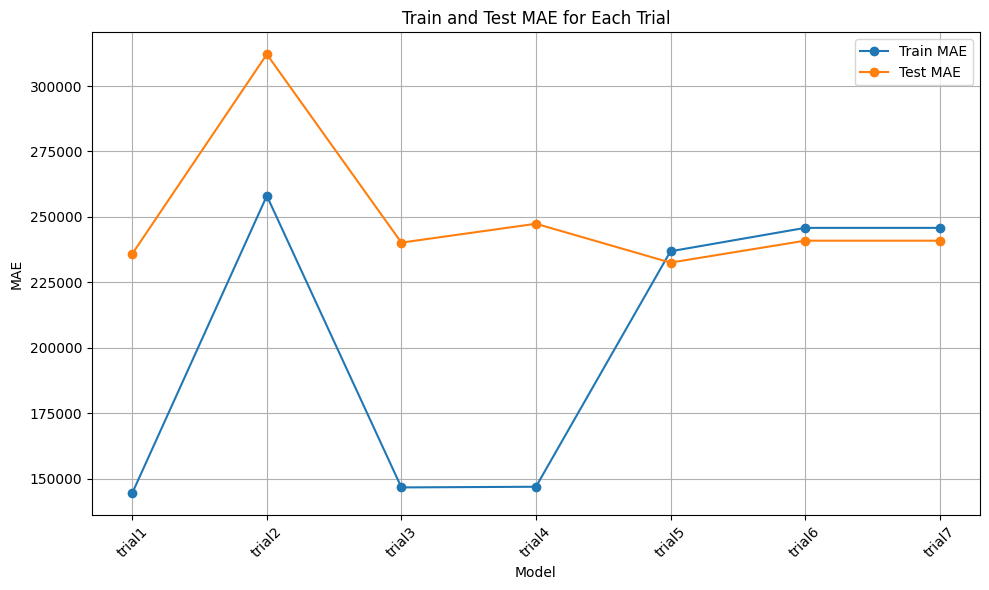

In [3]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(eval_df['model_id'], eval_df['train_mae'], marker='o', label='Train MAE')
plt.plot(eval_df['model_id'], eval_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Train and Test MAE for Each Trial')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [265]:
def hyperparameter_tune(regressor, X, y, param_grid):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=48)
    
    # Create a pipeline with the regressor
    pipeline = Pipeline([
        ("regressor", regressor)
    ])
    
    # Set up GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from the grid search
    best_regressor = grid_search.best_estimator_
    
    y_train_pred = best_regressor.predict(X_train)
    y_test_pred = best_regressor.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Train MAE: {:.2f}, Test MAE: {:.2f}".format(train_mae, test_mae))
    
    return best_regressor, grid_search

In [266]:
param_grid = {
    "regressor__n_estimators": [10, 25, 50, 75, 100, 200],
    "regressor__max_depth": [None, 5, 8, 10, 15, 20],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__bootstrap": [True, False],
    "regressor__n_jobs": [-1]
}

tuning_trial1 = RandomForestRegressor(random_state=0)
best_regressor, grid_search = hyperparameter_tune(tuning_trial1, X, y, param_grid)

Best Hyperparameters: {'regressor__bootstrap': True, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200, 'regressor__n_jobs': -1}
Train MAE: 197753.51, Test MAE: 227468.55


In [267]:
# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time   
0       0.084919      0.020061         0.025205        0.007221  \
1       0.165908      0.012589         0.030490        0.011333   
2       0.330568      0.036519         0.058773        0.022742   
3       0.497582      0.037784         0.067182        0.026228   
4       0.613765      0.035295         0.072125        0.009532   

  param_regressor__bootstrap param_regressor__max_depth   
0                       True                       None  \
1                       True                       None   
2                       True                       None   
3                       True                       None   
4                       True                       None   

  param_regressor__min_samples_leaf param_regressor__min_samples_split   
0                                 1                                  2  \
1                                 1                                  2   
2                                 1                                  2   
3                                 1                                  2   
4                                 1                                  2   

  param_regressor__n_estimators param_regressor__n_jobs   
0                            10                      -1  \
1                            25                      -1   
2                            50                      -1   
3                            75                      -1   
4                           100                      -1   

                                              params  split0_test_score   
0  {'regressor__bootstrap': True, 'regressor__max...           0.449951  \
1  {'regressor__bootstrap': True, 'regressor__max...           0.466845   
2  {'regressor__bootstrap': True, 'regressor__max...           0.464070   
3  {'regressor__bootstrap': True, 'regressor__max...           0.467496   
4  {'regressor__bootstrap': True, 'regressor__max...           0.466228   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score   
0           0.508418           0.462607           0.448250           0.389756  \
1           0.515030           0.460830           0.476052           0.427709   
2           0.521679           0.458431           0.483543           0.441405   
3           0.526641           0.457457           0.485410           0.438303   
4           0.524567           0.456362           0.484553           0.443365   

   mean_test_score  std_test_score  rank_test_score  
0         0.451796        0.037915              324  
1         0.469293        0.028087              312  
2         0.473826        0.027450              308  
3         0.475062        0.029953              299  
4         0.475015        0.028189              301